# ADC Peaks of an specific channel

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from scipy.stats import linregress
from sklearn.metrics import mean_squared_error
import seaborn as sns
import matplotlib.ticker as ticker

### ToT directory test

In [ ]:
# === Configuration for ToT ===
CONFIG_TOT = { 
    # "base_path": "/home/eic/Documents/internalinjection/PedestalStudies_InternalInjection_Oct2025/Linearity_Studies_Nov2025", 
    "base_path": "/home/lorena/Documents/PhD/EEEMCal_Analysis/Linearity_Studies_Nov2025", 
    "amplitudes": [400, 450, 925, 1450, 1975], 
    "fpga_pb_pairs": [
        ("208", "06"),
        ("209", "008")
    ],
    "runs": 5
}

# === Directory Generator Function for ToT ===
def generate_all_dirs_tot(config):
    all_dirs = {}
    
    for fpga, pb in config["fpga_pb_pairs"]:
        pair_key = f"fpga{fpga}_pb{pb}"
        all_dirs[pair_key] = {}
        
        for amp in config["amplitudes"]:
            all_dirs[pair_key][amp] = {
                i: f'{config["base_path"]}/{amp}dac/inj_adc_samples_{fpga}_pb{pb}_76_{amp}_{i+1}.csv'
                for i in range(config["runs"])
            }
            
    return all_dirs

# === Initialize Directories ===
all_dirs_tot = generate_all_dirs_tot(CONFIG_TOT)

# === Utility Functions ===
def get_path_tot(fpga, pb, amplitude, run, dirs_dict=all_dirs_tot):
    pair_key = f"fpga{fpga}_pb{pb}"
    try:
        return dirs_dict[pair_key][amplitude][run]
    except KeyError:
        raise ValueError(f"No path found for pair ({fpga}, {pb}), amplitude {amplitude}, and run {run}")

def list_all_paths_tot(dirs_dict=all_dirs_tot):
    return [
        path 
        for pair_dirs in dirs_dict.values()
        for amp_dirs in pair_dirs.values()
        for path in amp_dirs.values()
    ]

# === Example: Print All ToT Paths ===
# for path in list_all_paths_tot():
#     print(path)

# Show dictionary structure
# all_dirs_tot


{'fpga208_pb06': {400: {0: '/home/lorena/Documents/PhD/EEEMCal_Analysis/Linearity_Studies_Nov2025/400dac/inj_adc_samples_208_pb06_76_400_1.csv',
   1: '/home/lorena/Documents/PhD/EEEMCal_Analysis/Linearity_Studies_Nov2025/400dac/inj_adc_samples_208_pb06_76_400_2.csv',
   2: '/home/lorena/Documents/PhD/EEEMCal_Analysis/Linearity_Studies_Nov2025/400dac/inj_adc_samples_208_pb06_76_400_3.csv',
   3: '/home/lorena/Documents/PhD/EEEMCal_Analysis/Linearity_Studies_Nov2025/400dac/inj_adc_samples_208_pb06_76_400_4.csv',
   4: '/home/lorena/Documents/PhD/EEEMCal_Analysis/Linearity_Studies_Nov2025/400dac/inj_adc_samples_208_pb06_76_400_5.csv'},
  450: {0: '/home/lorena/Documents/PhD/EEEMCal_Analysis/Linearity_Studies_Nov2025/450dac/inj_adc_samples_208_pb06_76_450_1.csv',
   1: '/home/lorena/Documents/PhD/EEEMCal_Analysis/Linearity_Studies_Nov2025/450dac/inj_adc_samples_208_pb06_76_450_2.csv',
   2: '/home/lorena/Documents/PhD/EEEMCal_Analysis/Linearity_Studies_Nov2025/450dac/inj_adc_samples_208_p

### ADC directory test

In [5]:
# === Configuration ===
CONFIG = { 
    # "base_path": "/home/eic/Documents/internalinjection/PedestalStudies_InternalInjection_Oct2025/Linearity_Studies_Nov2025", 
    "base_path": "/home/lorena/Documents/PhD/EEEMCal_Analysis/Linearity_Studies_Nov2025", 
    "amplitudes": [100, 200, 300, 400], 
    "fpga_pb_pairs": [
        ("208", "06"),
        ("209", "008")
    ],
    "runs": 5
}

# === Directory Generator Function ===
def generate_all_dirs(config):
    all_dirs = {}
    
    for fpga, pb in config["fpga_pb_pairs"]:
        pair_key = f"fpga{fpga}_pb{pb}"
        all_dirs[pair_key] = {}
        
        for amp in config["amplitudes"]:
            all_dirs[pair_key][amp] = {
                i: f'{config["base_path"]}/{amp}dac/inj_adc_samples_{fpga}_pb{pb}_76_{amp}_{i+1}.csv'
                for i in range(config["runs"])
            }
            
    return all_dirs

# === Initialize Directories ===
all_dirs = generate_all_dirs(CONFIG)

# === Utility Functions ===
def get_path(fpga, pb, amplitude, run, dirs_dict=all_dirs):
    pair_key = f"fpga{fpga}_pb{pb}"
    try:
        return dirs_dict[pair_key][amplitude][run]
    except KeyError:
        raise ValueError(f"No path found for pair ({fpga}, {pb}), amplitude {amplitude}, and run {run}")

def list_all_paths(dirs_dict=all_dirs):
    return [
        path 
        for pair_dirs in dirs_dict.values()
        for amp_dirs in pair_dirs.values()
        for path in amp_dirs.values()
    ]

# # === Example: Print All Paths ===
# for path in list_all_paths():
#     print(path)

# # Show dictionary structure
# all_dirs


## Plot the waveform in all connected channels

Using file:
  /home/lorena/Documents/PhD/EEEMCal_Analysis/Linearity_Studies_Nov2025/400dac/inj_adc_samples_208_pb06_76_400_2.csv
Loaded 144 pedestal values for FPGA 208, PB 6


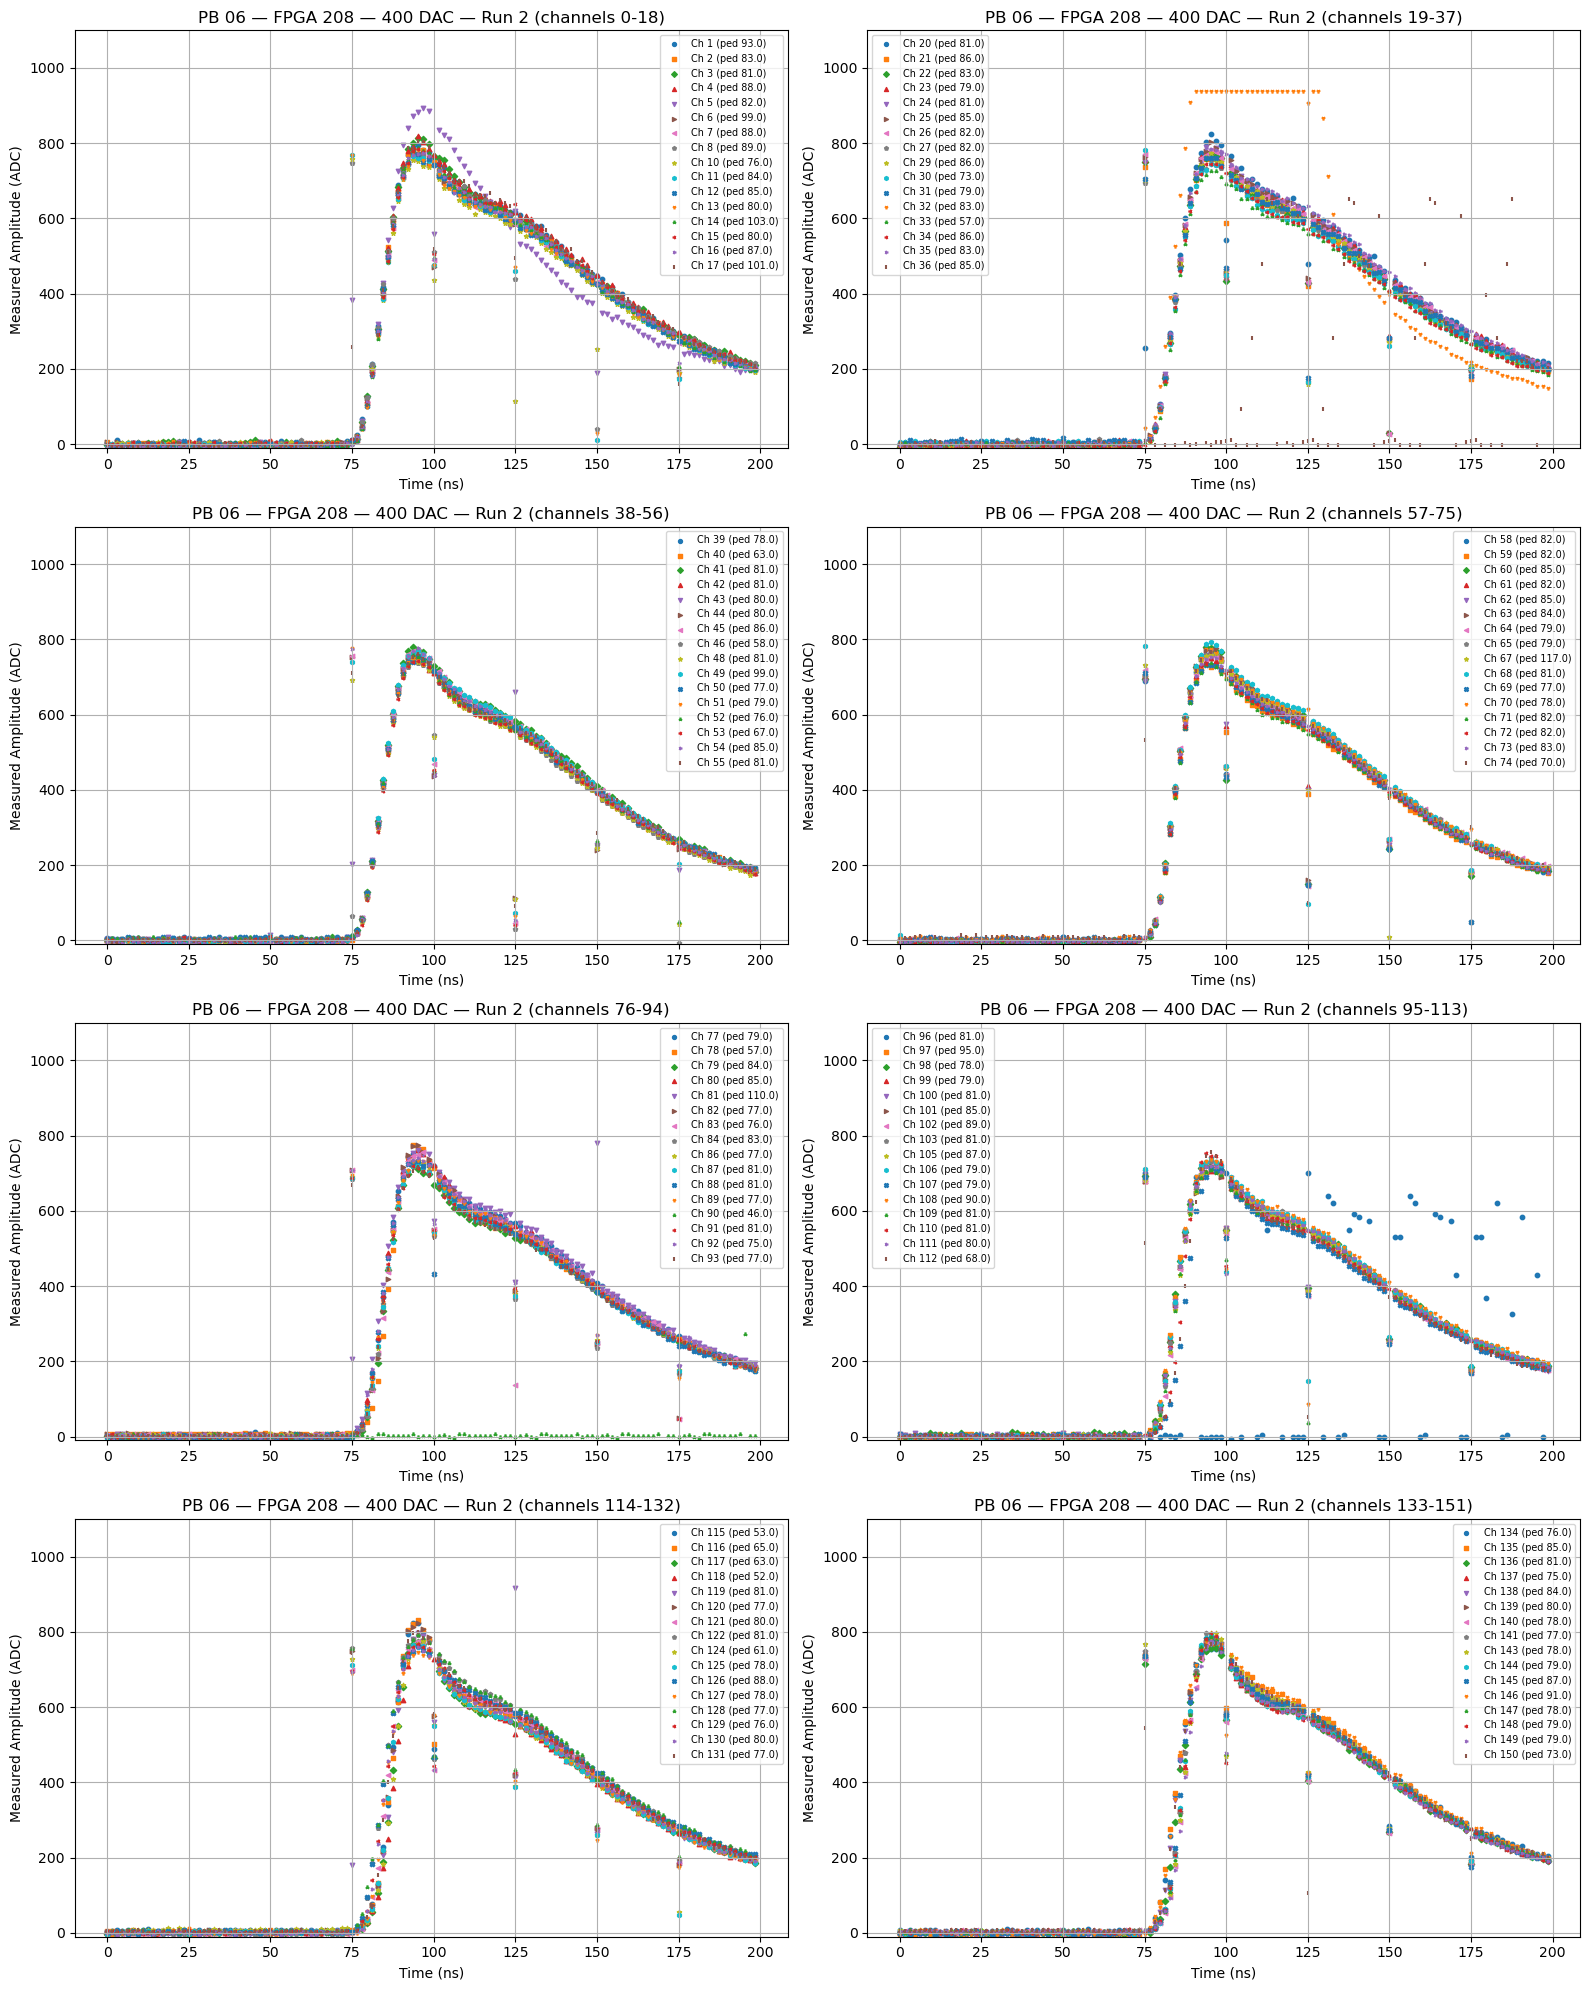

Figure saved to:
  /home/lorena/Documents/PhD/EEEMCal_Analysis/Linearity_Studies_Nov2025/images/FPGA_208_pb06/phases_fpga208-pb06_amp400_run2.png


In [8]:
# ========= Choices =========
pair_id = 0                 # 0 → (208,06), 1 → (209,008)
injected_amplitude = 400    # amplitude to plot
run_number = 2              # 1–5

# ========= Extract FPGA–PB pair from CONFIG =========
fpga_adc, pb_adc = CONFIG["fpga_pb_pairs"][pair_id]

pair_key = f"fpga{fpga_adc}_pb{pb_adc}"
run_idx = run_number - 1     # convert to index

# ========= Retrieve file =========
try:
    data_file = all_dirs[pair_key][injected_amplitude][run_idx]
except KeyError:
    print(f"No entry in all_dirs for {pair_key}, amplitude {injected_amplitude}, run {run_number}")
    raise

if not os.path.exists(data_file):
    print(f"File not found:\n{data_file}")
    raise SystemExit

print(f"Using file:\n  {data_file}")

# ========= Load pedestal CSV and build channel → pedestal map =========
PEDESTAL_CSV = "/home/lorena/Documents/PhD/EEEMCal_Analysis/Linearity_Studies_Nov2025/pedestals/pedestals_HV_modified_FPGA208_209.csv"

ped_df = pd.read_csv(PEDESTAL_CSV)

# Convert FPGA / PB to int to match the CSV (208, 6, 8, etc.)
fpga_int = int(fpga_adc)
pb_int = int(pb_adc)   # "06" → 6, "008" → 8

ped_sub = ped_df[(ped_df["FPGA"] == fpga_int) & (ped_df["PB"] == pb_int)]

# Build dict: channel -> pedestal (HV)
pedestal_map = ped_sub.set_index("Channel")["HV"].to_dict()

print(f"Loaded {len(pedestal_map)} pedestal values for FPGA {fpga_int}, PB {pb_int}")

# ========= Plotting code =========

fig, axs = plt.subplots(4, 2, figsize=(16, 20))
axs = axs.flatten()

markers = ['o', 's', 'D', '^', 'v', '>', '<', 'p', '*', 'h', 'X', '1', '2', '3', '4', '|']

dead_channels = {0, 37, 38, 75, 76, 113, 114, 151}
calibration_channels = {19, 57, 95, 133}
notConnected_channels = {9, 18, 28, 47, 56, 66, 85, 94, 104, 123, 132, 142}

num_groups = 8
files_per_group = 19

df = pd.read_csv(data_file)
df.columns = df.columns.str.strip()

# fallback pedestal if a channel has no entry in the CSV
fallback_pedestal = 80

for group_id in range(num_groups):
    ax = axs[group_id]
    first_channel = group_id * files_per_group
    last_channel = first_channel + files_per_group
    marker_index = 0

    for i in range(first_channel, last_channel):
        if i in dead_channels or i in calibration_channels or i in notConnected_channels:
            continue

        channel_data = df[df['Channel'] == i]
        if channel_data.empty:
            continue
        
        # Get pedestal for this channel
        ped_i = pedestal_map.get(i, fallback_pedestal)

        
        ax.scatter(
            channel_data['Time'],
            channel_data['ADC'] - ped_i,
            label=f'Ch {i} (ped {ped_i:.1f})',
            marker=markers[marker_index % len(markers)],
            s=10
        )
        marker_index += 1

    ax.set_title(
        f'PB {pb_adc} — FPGA {fpga_adc} — {injected_amplitude} DAC — Run {run_number} '
        f'(channels {first_channel}-{last_channel-1})'
    )
    ax.set_xlabel('Time (ns)')
    ax.set_ylabel('Measured Amplitude (ADC)')
    ax.set_ylim(-10, 1100)
    ax.grid(True)
    ax.legend(fontsize='x-small', markerscale=0.9)

plt.tight_layout()
plt.show()

# ========= Save figure =========
output_dir = f'/home/lorena/Documents/PhD/EEEMCal_Analysis/Linearity_Studies_Nov2025/images/FPGA_{fpga_adc}_pb{pb_adc}'
os.makedirs(output_dir, exist_ok=True)

output_path = os.path.join(
    output_dir,
    f'phases_fpga{fpga_adc}-pb{pb_adc}_amp{injected_amplitude}_run{run_number}.png'
)

fig.savefig(output_path, dpi=200)
print(f"Figure saved to:\n  {output_path}")

## Plot the waveform all all channels (mean value of runs) ADC

Loaded 144 pedestal values for FPGA 208, PB 6


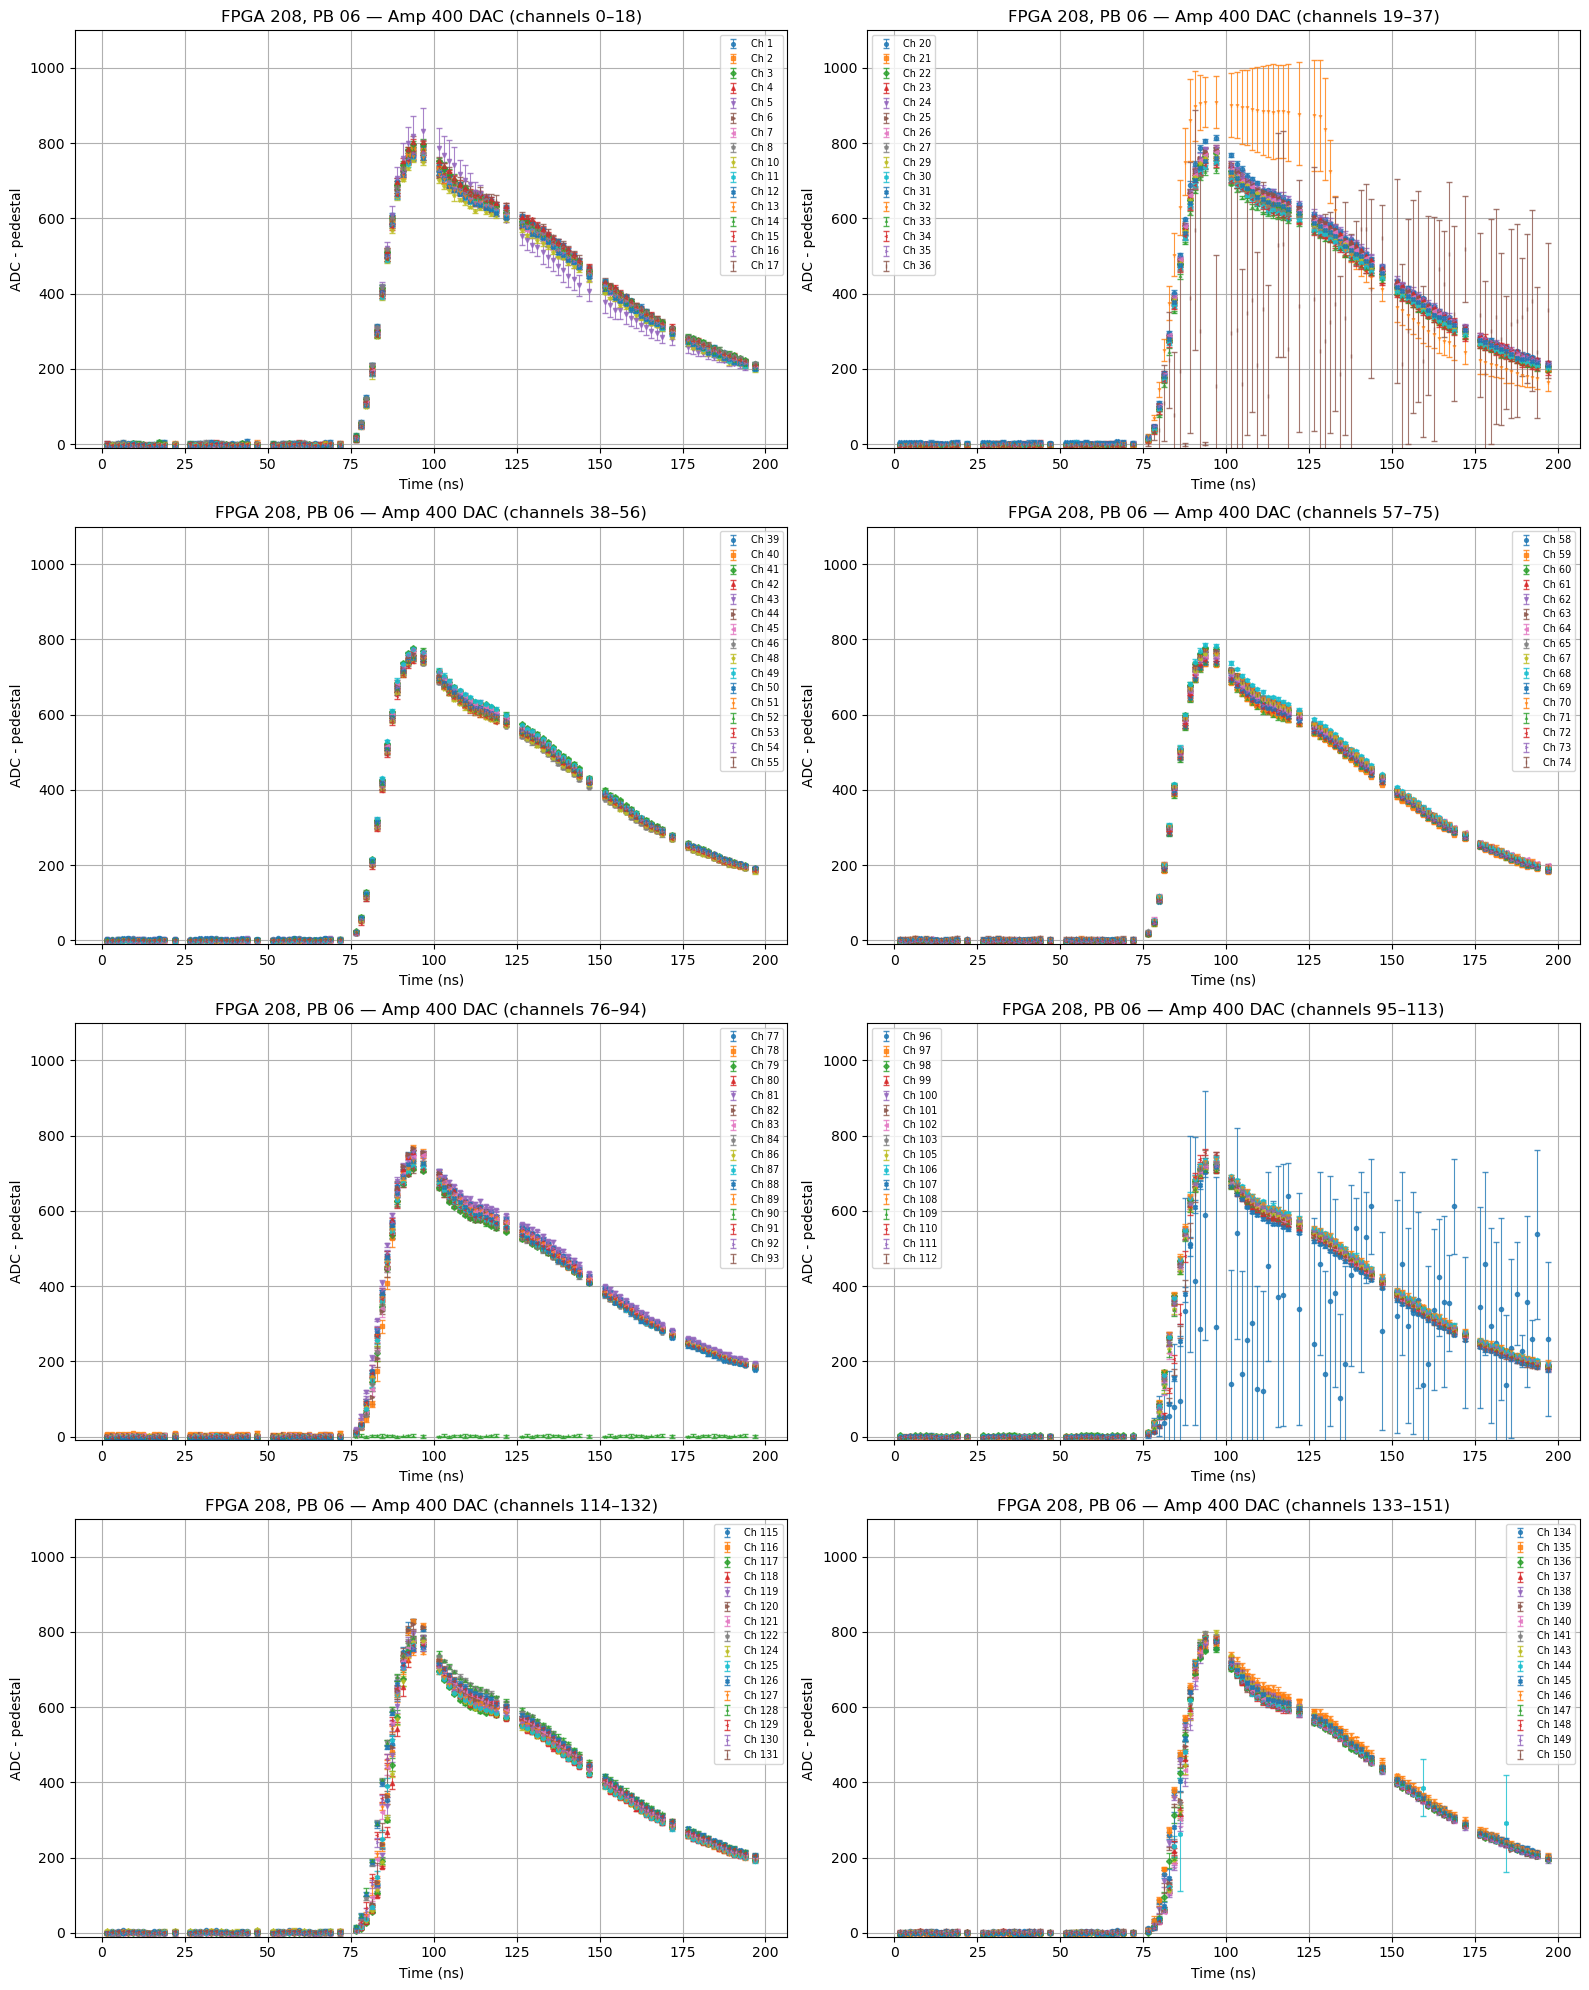

In [ ]:
# ========= User choices =========
pair_id = 0              # 0 → (208,06), 1 → (209,008)
injected_amplitude = 400  # amplitude to plot (must be in CONFIG["amplitudes"])

# ========= Get FPGA–PB pair from CONFIG =========
fpga_adc, pb_adc = CONFIG["fpga_pb_pairs"][pair_id]   # e.g. ("208", "06")
pair_key = f"fpga{fpga_adc}_pb{pb_adc}"

# ========= Extract the files for the specified amplitude and pair =========
try:
    run_files = all_dirs[pair_key][injected_amplitude]   # dict: run_idx -> file_path
except KeyError:
    print(f"No files found for pair {pair_key} and amplitude {injected_amplitude}")
    raise

# ========= Load pedestal CSV and build channel → pedestal map =========
ped_df = pd.read_csv(PEDESTAL_CSV)

fpga_int = int(fpga_adc)
pb_int   = int(pb_adc)   # "06" → 6, "008" → 8

ped_sub = ped_df[(ped_df["FPGA"] == fpga_int) & (ped_df["PB"] == pb_int)]
pedestal_map = ped_sub.set_index("Channel")["HV"].to_dict()

print(f"Loaded {len(pedestal_map)} pedestal values for FPGA {fpga_int}, PB {pb_int}")

# ========= Grouping settings =========
num_groups = 8
files_per_group = 19

# ========= Figure =========
fig, axs = plt.subplots(4, 2, figsize=(16, 20))
axs = axs.flatten()

# ========= Loop over channel groups =========
for group_id in range(num_groups):
    ax = axs[group_id]
    first_channel = group_id * files_per_group
    last_channel = first_channel + files_per_group
    marker_index = 0

    for channel in range(first_channel, last_channel):
        # Skip unwanted channels
        if (channel in dead_channels or
            channel in calibration_channels or
            channel in notConnected_channels):
            continue

        # Get pedestal for this channel
        ped_i = pedestal_map.get(channel, fallback_pedestal)

        # Collect data across all runs
        all_runs_data = []

        for run_idx, file_path in run_files.items():
            if not os.path.exists(file_path):
                print(f"File not found: {file_path}")
                continue

            df = pd.read_csv(file_path)
            df.columns = df.columns.str.strip()

            # Filter by channel and remove unwanted phases
            channel_data = df[
                (df['Channel'] == channel) &
                (~df['Phase'].isin([4, 6, 7]))
            ]

            if channel_data.empty:
                continue

            # Work on a copy to avoid SettingWithCopy warnings
            channel_data = channel_data.copy()

            # Subtract per-channel pedestal
            channel_data['ADC'] = channel_data['ADC'] - ped_i

            all_runs_data.append(channel_data[['Time', 'ADC']])

        # If we collected data from any run for this channel
        if all_runs_data:
            combined_data = pd.concat(all_runs_data)

            # Compute mean and std per Time bin
            stats = (
                combined_data
                .groupby('Time')['ADC']
                .agg(['mean', 'std'])
                .reset_index()
            )

            # Plot mean with error bars (std)
            ax.errorbar(
                stats['Time'],
                stats['mean'],
                yerr=stats['std'],
                fmt=markers[marker_index % len(markers)],
                markersize=3,
                capsize=2,
                elinewidth=0.8,
                label=f'Ch {channel}',
                alpha=0.8,
            )
            marker_index += 1

    ax.set_title(
        f'FPGA {fpga_adc}, PB {pb_adc} — Amp {injected_amplitude} DAC '
        f'(channels {first_channel}–{last_channel - 1})'
    )
    ax.set_xlabel('Time (ns)')
    ax.set_ylabel('ADC - pedestal')
    ax.set_ylim(-10, 1100)
    ax.grid(True)
    ax.legend(fontsize='x-small', markerscale=0.9)

plt.tight_layout()
plt.show()

# Optional save:
output_dir = f'/home/lorena/Documents/PhD/EEEMCal_Analysis/Linearity_Studies_Nov2025/images/FPGA_{fpga_adc}_pb{pb_adc}'
os.makedirs(output_dir, exist_ok=True)
fig.savefig(os.path.join(output_dir, f'MeanChannelsWithError_fpga{fpga_adc}-pb{pb_adc}_{injected_amplitude}DAC.png'))

## Plot the TOT - 12b all channels (mean value of runs)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

No files found for amplitude 1450


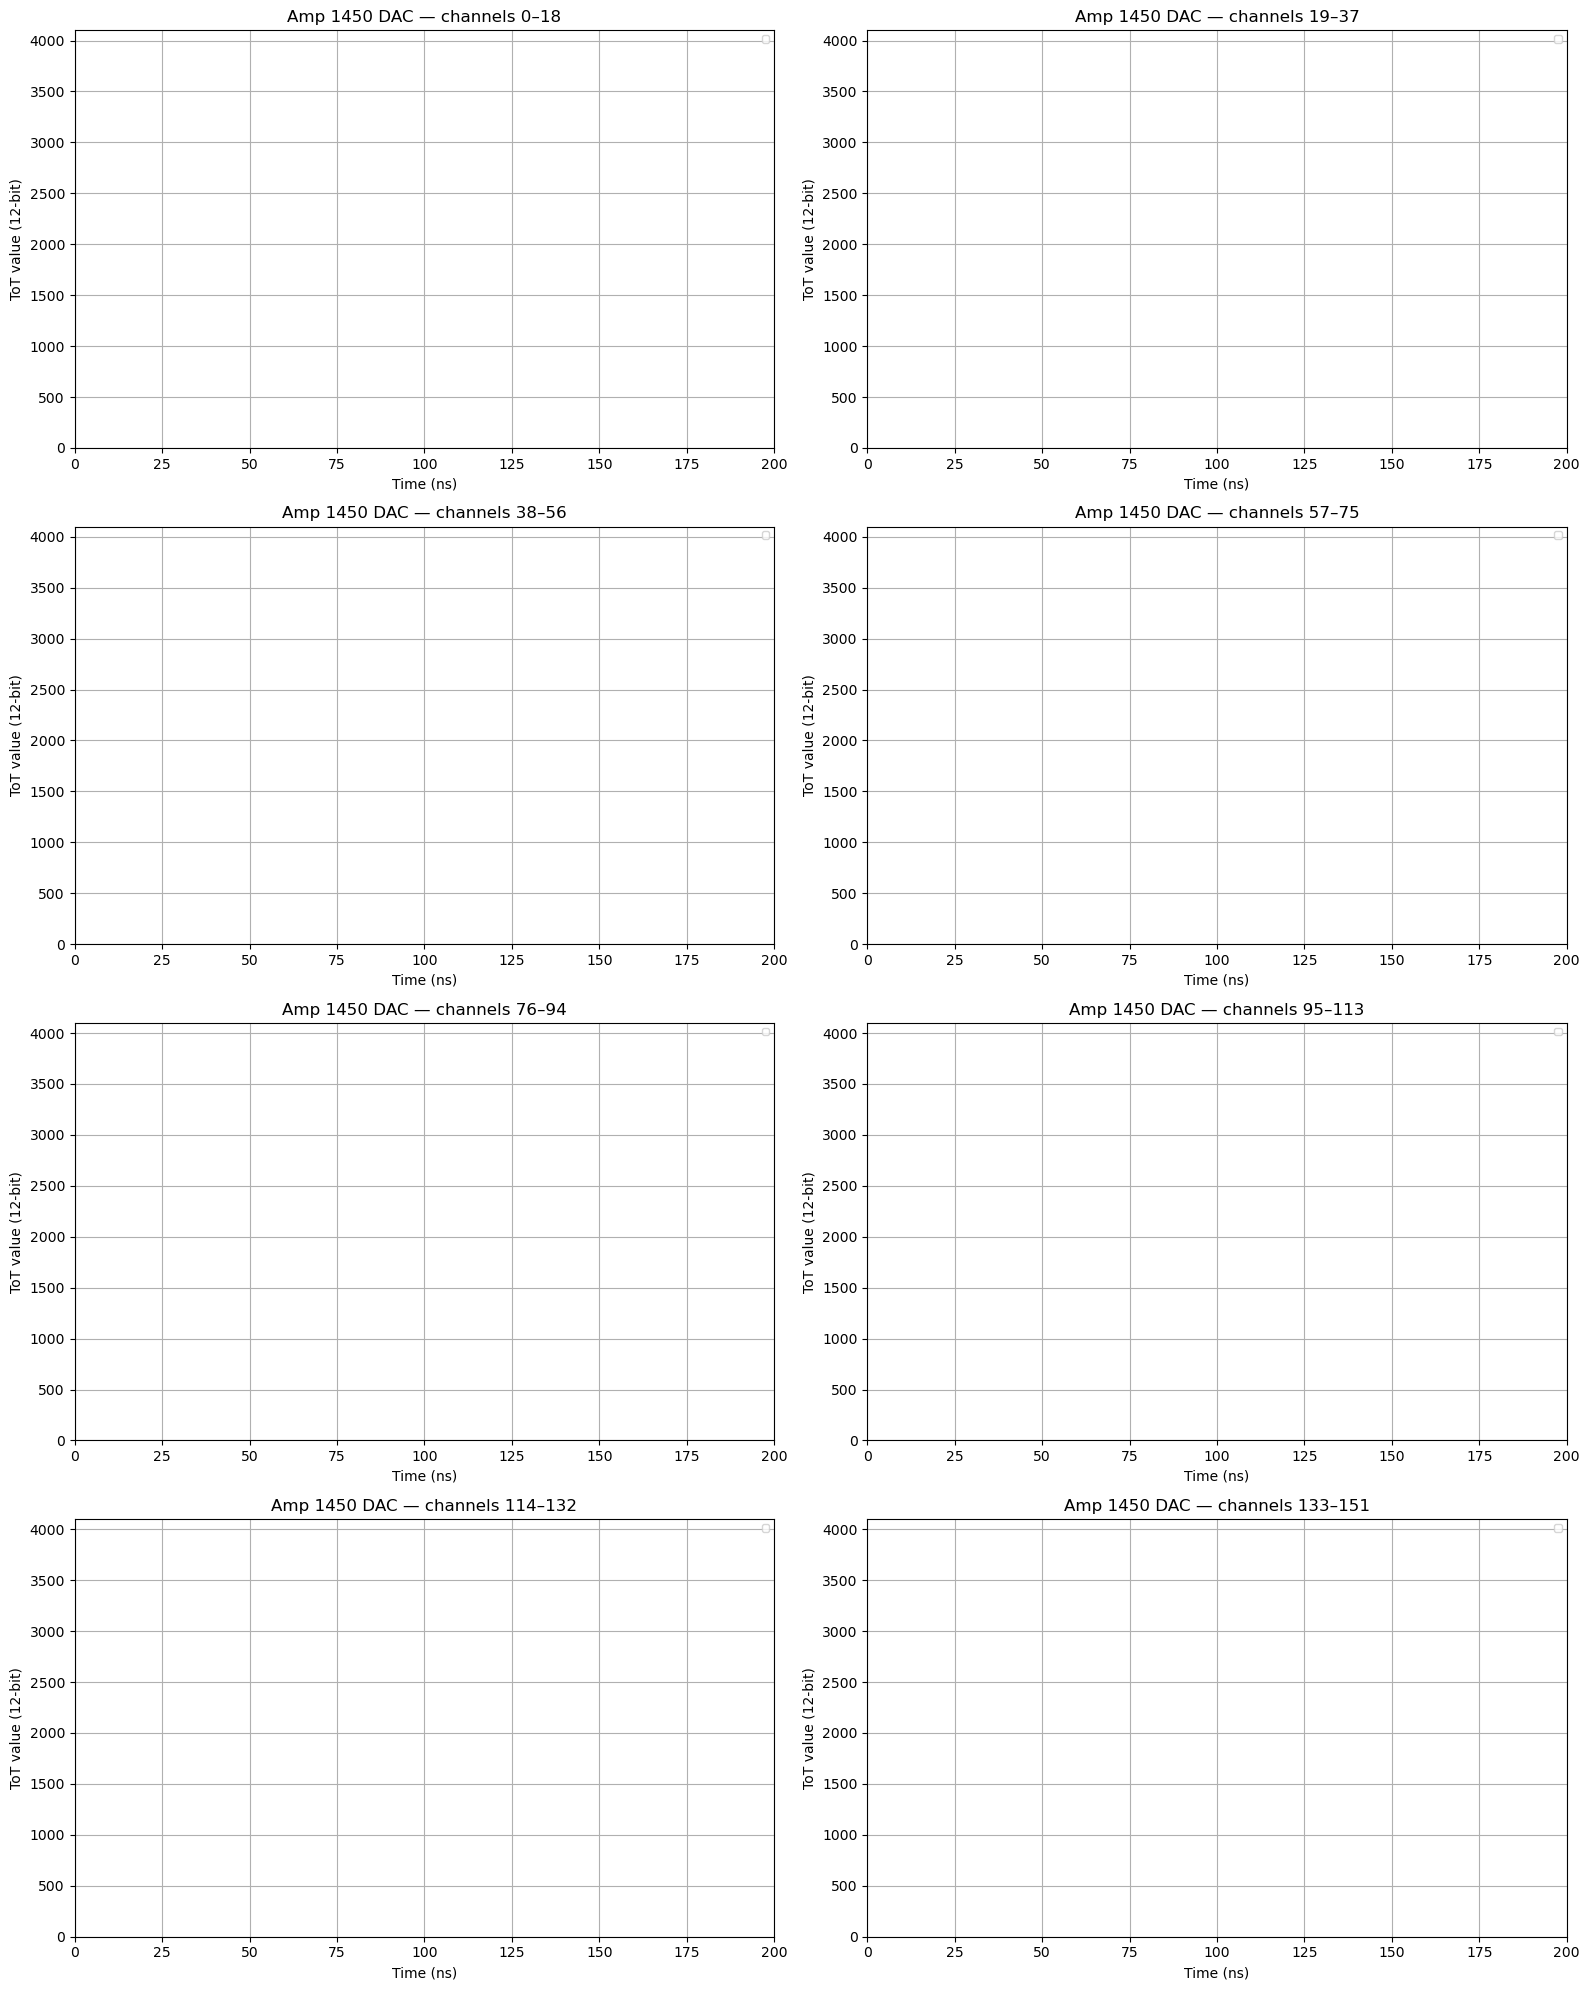


🟢 Approved ToT Channels (0 channels):


🔴 Discarded ToT Channels (0 channels):


Percentage of Approved Linearity Channels: 0.00%


: 

In [ ]:
# ========= User choices =========

# Specify the amplitude you want to plot
injected_amplitude = 1450  # Replace with the desired amplitude

# ========= Extract files for the specified amplitude =========
run_files = all_dirs_tot.get(injected_amplitude, {})

# Check if the amplitude is valid
if not run_files:
    print(f"No files found for amplitude {injected_amplitude}")
    exit()

# ========= Channel masks (dead / calibration / not connected) =========
dead_channels = {0, 37, 38, 75, 76, 113, 114, 151}
calibration_channels = {19, 57, 95, 133}
notConnected_channels = {9, 18, 28, 47, 56, 66, 85, 94, 104, 123, 132, 142}

# ========= Grouping settings =========
num_groups = 8
files_per_group = 19

# ========= Figure =========
# Create a figure with 4x2 subplots
fig, axs = plt.subplots(4, 2, figsize=(16, 20))
axs = axs.flatten()


approved_tot_channels = []
discarded_tot_channels = []

# ========= Loop over channel groups =========
for group_id in range(num_groups):
    ax = axs[group_id]
    first_channel = group_id * files_per_group
    last_channel = first_channel + files_per_group
    marker_index = 0

    for channel in range(first_channel, last_channel):
        # Skip unwanted channels
        if (channel in dead_channels or
            channel in calibration_channels or
            channel in notConnected_channels):
            continue
        
        # -------- Collect data across all runs for this channel --------
        all_runs_data = []

        for run_number, file_path in run_files.items():
            if not os.path.exists(file_path):
                print(f"File not found: {file_path}")
                continue
            
            # Read the data file
            df = pd.read_csv(file_path)
            df.columns = df.columns.str.strip()
            
            # Filter by channel and remove unwanted phases
            # channel_data = df[(df['Channel'] == channel) & (~df['Phase'].isin([4, 6, 7]))]
            channel_data = df[(df['Channel'] == channel)]
            
            # Work on a copy to avoid SettingWithCopy warnings
            channel_data = channel_data.copy()
            
            # For ToT there is NO pedestal subtraction → keep raw ToT
            channel_data['TOT_12bit'] = channel_data['TOT_12bit'].astype(float)
            
            all_runs_data.append(channel_data[['Time', 'TOT_12bit']])

        # -------- If we collected data from any run for this channel --------
        # If data was collected for all runs, compute the mean
        if all_runs_data:
            # Concatenate all runs for this channel
            combined_data = pd.concat(all_runs_data)
            
            # Compute the mean ToT for each time bin
            mean_data = (
                combined_data
                .groupby('Time')['TOT_12bit']
                .mean()
                .reset_index()
            )
            std_data = (
                combined_data
                .groupby('Time')['TOT_12bit']
                .std()
                .reset_index()
            )

            
            # Plot the mean waveform
            # Compute standard deviation of the mean waveform
            # Remove zeros before computing channel-level stats
            nonzero = mean_data[mean_data['TOT_12bit'] > 0]['TOT_12bit']
            tot_mean = nonzero.mean() if not nonzero.empty else 0
            mean_std = nonzero.std() if not nonzero.empty else 0

            # Plot the mean waveform and add std to the legend
            #ax.scatter(mean_data['Time'], mean_data['TOT_12bit'], label=f'Ch {channel} (σ̄={mean_std:.1f})', alpha=0.8, s=10)

            # Plot the mean waveform and capture the color (per time bin)
            points = ax.scatter(
                mean_data['Time'],
                mean_data['TOT_12bit'],
                label=f'Ch {channel} (μ={tot_mean:.1f}, σ={mean_std:.1f})',
                alpha=0.8,
                s=10,
            )

            color = points.get_facecolor()[0]  # RGBA color

            # Draw horizontal line in same color, less opaque
            # Draw horizontal line at mean ToT for this channel
            color = points.get_facecolor()[0]
            if tot_mean > 0:
                ax.axhline(
                    y=tot_mean,
                    color=color,
                    linestyle='--',
                    linewidth=1,
                    alpha=0.4,
                )
            '''ax.text(x=ax.get_xlim()[0] + 2, y=tot_mean + 10,
                    s=f"μ={tot_mean:.1f}", fontsize=7, color=color, alpha=0.6)'''

            # Classify channel based on relative fluctuation
            if tot_mean > 0 and mean_std * 100 / tot_mean <= 20:
                approved_tot_channels.append(channel)
            else:
                discarded_tot_channels.append(channel)
            
            #ax.errorbar(mean_data['Time'], mean_data['TOT_12bit'], yerr=std_data['TOT_12bit'], fmt='', linestyle="None")
            marker_index += 1

    ax.set_title(
        f'Amp {injected_amplitude} DAC — channels {first_channel}–{last_channel - 1}'
    )
    ax.set_xlabel('Time (ns)')
    ax.set_ylabel('ToT value (12-bit)')
    ax.set_ylim(0, 4100)
    ax.set_xlim(0, 200)
    ax.grid(True)
    ax.legend(fontsize='x-small', markerscale=0.9)

# ========= Final layout & display =========
plt.tight_layout()
plt.show()

#fig.savefig(f'/home/eic/Documents/HGCSoft/h2gcalib_3b/internalinjection/images/FPGA_{fpga_tot}_pb{pb_tot}/04_MeanConnectedChannelsAllRuns_tot_12bit_fpga{fpga_tot}-pb{pb_tot}_{injected_amplitude}DAC.png')

# ========= Helpers for printing channel lists =========
def print_channel_list(label, channels):
    print(f"\n{label} ({len(channels)} channels):")
    print(", ".join(str(int(c)) for c in sorted(channels)))
# ========= Summary: approved / discarded channels =========
print_channel_list("🟢 Approved ToT Channels", approved_tot_channels)
print_channel_list("🔴 Discarded ToT Channels", discarded_tot_channels)

# ========= Percentage of approved channels (w.r.t. 128 physical channels) =========
total_channels = 128
percentage_good = (len(approved_tot_channels) / total_channels) * 100
print(f"\nPercentage of Approved Linearity Channels: {percentage_good:.2f}%")


In [ ]:
# ========= User choices =========
pair_id = 0                # 0 → (208,06), 1 → (209,008)
injected_amplitude = 1450  # must be in CONFIG_TOT["amplitudes"]

# ========= Get FPGA–PB pair from CONFIG_TOT =========
fpga_tot, pb_tot = CONFIG_TOT["fpga_pb_pairs"][pair_id]
pair_key = f"fpga{fpga_tot}_pb{pb_tot}"

# ========= Extract files for this pair + amplitude =========
try:
    run_files = CONFIG_TOT["runs"]  # number of runs, for clarity
    run_files = all_dirs_tot[pair_key][injected_amplitude]  # dict: run_idx -> path
except KeyError:
    print(f"No files found for pair {pair_key} and amplitude {injected_amplitude}")
    raise

if not run_files:
    print(f"No files found for amplitude {injected_amplitude}")
    raise SystemExit

# ========= Preload all runs once =========
run_dfs = {}
for run_idx, file_path in run_files.items():
    if not os.path.exists(file_path):
        print(f"File not found: {file_path}")
        continue
    df = pd.read_csv(file_path)
    df.columns = df.columns.str.strip()
    run_dfs[run_idx] = df

if not run_dfs:
    print("No valid run files loaded.")
    raise SystemExit

# ========= Plotting =========
fig, axs = plt.subplots(4, 2, figsize=(16, 20))
axs = axs.flatten()



## Extract adc peak per amplitude ADC

In [ ]:
def extract_peaks(all_dirs, channel, pedestals):
    amplitudes_list = [] 
    peaks_list = [] 
    
    for amplitude, runs in all_dirs.items():
        for run_file in runs.values():
            if os.path.exists(run_file):
                # Read the CSV file
                df = pd.read_csv(run_file)
                df.columns = df.columns.str.strip()
                
                # Check for required columns
                if 'Channel' in df.columns and 'ADC' in df.columns and 'Phase' in df.columns:
                    # Filter by the specified channel and exclude unwanted phases
                    channel_data = df[(df['Channel'] == channel) & (~df['Phase'].isin([4, 6, 7]))]
                    
                    # Extract the peak value if the channel data is not empty
                    if not channel_data.empty:
                        peak = channel_data['ADC'].max()-pedestals
                        amplitudes_list.append(amplitude)
                        peaks_list.append(peak)
                else:
                    print(f"Required columns missing in {run_file}")
            else:
                print(f"File not found: {run_file}")
    
    return amplitudes_list, peaks_list


## Extract adc peak per amplitude dynamic pedestals

In [ ]:
def extract_peaks_pedestals_dynamic(all_dirs, channel, pb, pedestal_files, default_pedestals):
    if default_pedestals is None:
        default_pedestals = {}

    if pb not in pedestal_files:
        raise ValueError(f"No pedestal file provided for protoboard {pb}")
    
    pedestal_file_path = pedestal_files[pb]
    if not os.path.exists(pedestal_file_path):
        raise FileNotFoundError(f"Pedestal file for protoboard {pb} not found: {pedestal_file_path}")

    # Load the pedestal file for the current protoboard
    pedestal_df = pd.read_csv(pedestal_file_path)
    pedestal_df.columns = pedestal_df.columns.str.strip()
    pedestal_df = pedestal_df[~pedestal_df['Phase'].isin([4, 6, 7])]
    pedestal_df = pedestal_df[pedestal_df['Channel'] == channel]

    # Check if pedestal data exists for the channel
    pedestal_map = {}
    use_default = False
    default_pedestal = None

    if pedestal_df.empty:
        if pb in default_pedestals and channel in default_pedestals[pb]:
            default_pedestal = default_pedestals[pb][channel]
            use_default = True
            print(f"No pedestal data found for channel {channel} on protoboard {pb}, using calibration pedestal value of {default_pedestal}.")
        else:
            print(f"No pedestal data found for channel {channel} on protoboard {pb}, and no default value specified.")
            return [], []
    else:
        pedestal_map = pedestal_df.set_index('Phase')['ADC'].to_dict()

    amplitudes_list = [] 
    peaks_list = [] 
    
    for amplitude, runs in all_dirs.items():
        for run_file in runs.values():
            if os.path.exists(run_file):
                df = pd.read_csv(run_file)
                df.columns = df.columns.str.strip()

                if {'Channel', 'ADC', 'Phase'}.issubset(df.columns):
                    channel_data = df[(df['Channel'] == channel) & (~df['Phase'].isin([4, 6, 7]))]

                    if not channel_data.empty:
                        if use_default:
                            corrected_adc = channel_data['ADC'] - default_pedestal
                        else:
                            corrected_adc = channel_data.apply(
                                lambda row: row['ADC'] - pedestal_map.get(row['Phase'], 80),
                                axis=1
                            )

                        peak = corrected_adc.max()
                        amplitudes_list.append(amplitude)
                        peaks_list.append(peak)
                else:
                    print(f"Required columns missing in {run_file}")
            else:
                print(f"File not found: {run_file}")
    
    return amplitudes_list, peaks_list



### Extract tot peak per amplitude

In [ ]:
def extract_tot_peak(all_dirs, channel, pedestals):
    amplitudes_list = [] 
    peaks_list = [] 
    
    for amplitude, runs in all_dirs.items():
        for run_file in runs.values():
            if os.path.exists(run_file):
                # Read the CSV file
                df = pd.read_csv(run_file)
                df.columns = df.columns.str.strip()
                
                # Check for required columns
                if 'Channel' in df.columns and 'ADC' in df.columns and 'TOT_12bit' in df.columns and 'Phase' in df.columns:
                    # Filter by the specified channel and exclude unwanted phases
                    channel_data = df[(df['Channel'] == channel) ]#& (~df['Phase'].isin([4, 6, 7]))]
                    
                    # Extract the peak value if the channel data is not empty
                    if not channel_data.empty:
                        peak = channel_data['TOT_12bit'].max()-pedestals
                        amplitudes_list.append(amplitude)
                        peaks_list.append(peak)
                    else:
                        print('Channel data empty')
                else:
                    print(f"Required columns missing in {run_file}")
            else:
                print(f"File not found: {run_file}")
    
    return amplitudes_list, peaks_list


### Extract tot mean per amplitude

In [ ]:
def extract_tot_mean(all_dirs, channel, pedestals):
    amplitudes_list = [] 
    means_list = [] 
    
    for amplitude, runs in all_dirs.items():
        for run_file in runs.values():
            if os.path.exists(run_file):
                # Read the CSV file
                df = pd.read_csv(run_file)
                df.columns = df.columns.str.strip()
                
                # Check for required columns
                if {'Channel', 'ADC', 'TOT_12bit', 'Phase'}.issubset(df.columns):
                    # Filter by the specified channel
                    channel_data = df[(df['Channel'] == channel) & (~df['Phase'].isin([4, 6, 7]))]
                    print(df[df['Channel'] == channel]['Phase'].unique())
                    # Ensure TOT_12bit is not zero
                    if channel_data.empty:
                        print(f"No data for channel {channel} in {run_file}")
                        continue
                    
                    # Exclude TOT_12bit == 0
                    valid_tot = channel_data[channel_data['TOT_12bit'] != 0]['TOT_12bit']
                    
                    # Compute the mean if there are valid entries
                    if not valid_tot.empty:
                        mean_val = valid_tot.mean() - pedestals
                        amplitudes_list.append(amplitude)
                        means_list.append(mean_val)
                    else:
                        print(f"No valid TOT_12bit data (non-zero) in {run_file} for channel {channel}")
                else:
                    print(f"Required columns missing in {run_file}")
            else:
                print(f"File not found: {run_file}")
    
    return amplitudes_list, means_list


### Peak ADC vs DAC of an specific channel

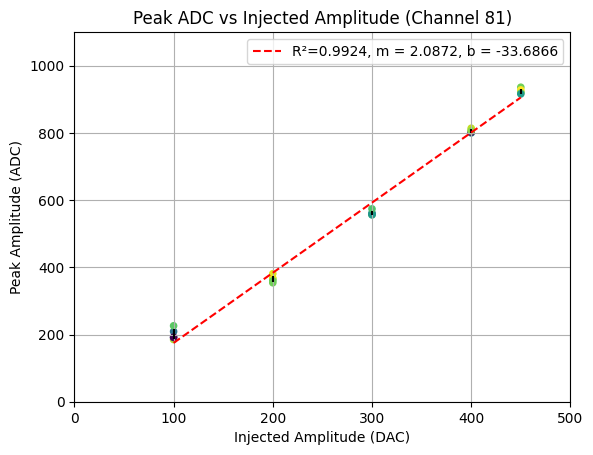

In [ ]:
# Define the channel to plot 
channel = 81
pedestals = 80
amplitudes, peaks = extract_peaks(all_dirs, channel, pedestals) 

amplitudes_array = np.array(amplitudes) 
#amplitudes_pC = (amplitudes_array - 193.03)/49 #pC

peaks_np = np.array(peaks)
means = peaks_np.reshape(-1,5).mean(axis=1)
std_dev = peaks_np.reshape(-1,5).std(axis=1)

# Linear regression 
slope, intercept, r_value, p_value, std_err = linregress(amplitudes_array, peaks) 

# Plotting 
colors = np.random.rand(25)

fig = plt.figure() 
plt.scatter(amplitudes_array, peaks, s=20, c=colors)
#plt.scatter(np.array([100, 200, 300, 400, 450]), means, s=20, c=colors) 
plt.errorbar(np.array([100, 200, 300, 400, 450]), means, yerr=std_dev, fmt='', linestyle="None", c='black')
plt.xlabel('Injected Amplitude (DAC)') 
plt.plot(amplitudes_array, slope*amplitudes_array + intercept, linestyle="--", color='red', label=f'R²={r_value**2:.4f}, m = {slope:.4f}, b = {intercept:.4f}') 
plt.ylabel('Peak Amplitude (ADC)') 
plt.title(f'Peak ADC vs Injected Amplitude (Channel {channel})') 
plt.ylim(0,1100)
plt.xlim(0,500)
plt.grid(True)
plt.legend()
#fig.savefig(f'/home/eic/Documents/HGCSoft/h2gcalib_3b/internalinjection/images/FPGA_{fpga}_pb{pb}/05_Peaks-Ch{channel}-{fpga}-pb{pb}.png')
plt.show() 


[ 7  8  9 10 11 12 13 14 15  0  1  2  3  4  5  6]
[ 7  8  9 10 11 12 13 14 15  0  1  2  3  4  5  6]
[ 7  8  9 10 11 12 13 14 15  0  1  2  3  4  5  6]
[ 7  8  9 10 11 12 13 14 15  0  1  2  3  4  5  6]
[ 7  8  9 10 11 12 13 14 15  0  1  2  3  4  5  6]
[ 7  8  9 10 11 12 13 14 15  0  1  2  3  4  5  6]
[ 7  8  9 10 11 12 13 14 15  0  1  2  3  4  5  6]
[ 7  8  9 10 11 12 13 14 15  0  1  2  3  4  5  6]
[ 7  8  9 10 11 12 13 14 15  0  1  2  3  4  5  6]
[ 7  8  9 10 11 12 13 14 15  0  1  2  3  4  5  6]
[ 7  8  9 10 11 12 13 14 15  0  1  2  3  4  5  6]
[ 7  8  9 10 11 12 13 14 15  0  1  2  3  4  5  6]
[ 7  8  9 10 11 12 13 14 15  0  1  2  3  4  5  6]
[ 7  8  9 10 11 12 13 14 15  0  1  2  3  4  5  6]
[ 7  8  9 10 11 12 13 14 15  0  1  2  3  4  5  6]
[ 7  8  9 10 11 12 13 14 15  0  1  2  3  4  5  6]
[ 7  8  9 10 11 12 13 14 15  0  1  2  3  4  5  6]
[ 7  8  9 10 11 12 13 14 15  0  1  2  3  4  5  6]
[ 7  8  9 10 11 12 13 14 15  0  1  2  3  4  5  6]
[ 7  8  9 10 11 12 13 14 15  0  1  2  3  4  5  6]


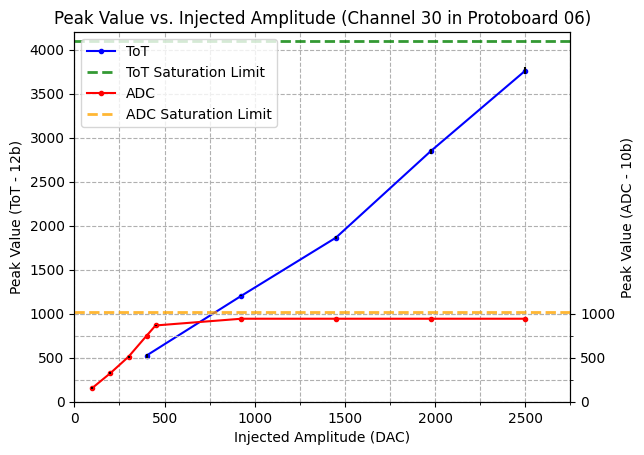

In [ ]:
# Pedestal files for each protoboard
pedestal_file_path = {'01': '/home/eic/Documents/HGCSoft/h2gcalib_3b/internalinjection/0dac/inj_adc_samples_208_pb01_76I_0_1.csv', 
                      '008': '/home/eic/Documents/HGCSoft/h2gcalib_3b/internalinjection/0dac/inj_adc_samples_209_pb008_76I_0_1.csv',
                      '06': '/home/eic/Documents/HGCSoft/h2gcalib_3b/internalinjection/0dac/inj_adc_samples_210_pb06_76I_0_1.csv'}

# Default pedestal values for each protoboard from the pedestal calibration files
default_pedestals = {'01': {79: 35, 83: 50, 115: 80, 116: 76, 117: 75},
                     '008': {},
                     '06': {}}

# Define the channel to plot 
channel = 30
pedestals = 80
amplitudes_tot, peaks_tot = extract_tot_mean(all_dirs_tot, channel, pedestals=0)
amplitudes_adc, peaks_adc = extract_peaks_pedestals_dynamic(all_dirs, channel, pb=pb_adc, pedestal_files=pedestal_file_path, default_pedestals=default_pedestals)
amplitudes_adc_over_450, peaks_adc_over_450 = extract_peaks(all_dirs_tot, channel, pedestals)

amplitudes_array = np.array(amplitudes_tot)
amplitudes_adc_array = np.array(amplitudes_adc) 
#amplitudes_pC = (amplitudes_array - 193.03)/49 #pC

peaks_tot_np = np.array(peaks_tot)
means_tot = peaks_tot_np.reshape(-1,5).mean(axis=1)
std_dev_tot = peaks_tot_np.reshape(-1,5).std(axis=1)

peaks_adc_np = np.array(peaks_adc)
means_adc = peaks_adc_np.reshape(-1,5).mean(axis=1)
std_dev_adc = peaks_adc_np.reshape(-1,5).std(axis=1)

peaks_adc_over_450_np = np.array(peaks_adc_over_450)
means_adc_over_450 = peaks_adc_over_450_np.reshape(-1,5).mean(axis=1)
std_dev_adc_over_450 = peaks_adc_over_450_np.reshape(-1,5).std(axis=1)

means_adc_all = np.concatenate((means_adc, means_adc_over_450[1:]), axis=0)
std_dev_adc_all = np.concatenate((std_dev_adc, std_dev_adc_over_450[1:]), axis=0)

# Linear regression 
#slope, intercept, r_value, p_value, std_err = linregress(amplitudes_array, peaks) 

# Plotting 
colors = np.random.rand(5)

fig, ax1 = plt.subplots()
line1, = ax1.plot(np.array([400, 925, 1450, 1975, 2500]), means_tot, c='blue', marker=".", label = 'ToT')
ax1.errorbar(np.array([400, 925, 1450, 1975, 2500]), means_tot, yerr=std_dev_tot, fmt='', linestyle="None", c='black')
ax1.set_xlabel('Injected Amplitude (DAC)') 
ax1.set_ylabel('Peak Value (ToT - 12b)') 
ax1.set_ylim(0,4200)
ax1.set_xlim(0,2750)
#ax1.grid(True)

ax1.xaxis.set_major_locator(ticker.MultipleLocator(500))
ax1.xaxis.set_minor_locator(ticker.MultipleLocator(250))

ax1.grid(True, which='both', axis='both', linestyle = '--')

ax2 = ax1.twinx()

line2, = ax2.plot(np.array([100, 200, 300, 400, 450, 925, 1450, 1975, 2500]), means_adc_all, c='red', marker='.', label = 'ADC')
ax2.errorbar(np.array([100, 200, 300, 400, 450, 925, 1450, 1975, 2500]), means_adc_all, yerr=std_dev_adc_all, fmt='', linestyle="None", c='black')
ax2.set_ylabel('Peak Value (ADC - 10b)')
ax2.set_ylim(0,4200)

#ticks_to_show = range(0, 1024, 200)
#ax2.set_yticks(ticks_to_show)
#ax2.set_yticklabels(['' for _ in ticks_to_show])

minor_ticks = list(range(0,1024,250))
major_ticks = list(range(0,1024,500))

ax2.set_yticks(major_ticks)
ax2.set_yticks(minor_ticks, minor=True)

ax2.yaxis.grid(True, which='both', linestyle='--')

hline2 = ax2.axhline(y=1024, color='orange', linestyle='--', linewidth = 2, alpha=0.8, label = 'ADC Saturation Limit')
hline1 = ax1.axhline(y=4096, color='green', linestyle='--', linewidth = 2, alpha=0.8, label = 'ToT Saturation Limit')

plt.title(f'Peak Value vs. Injected Amplitude (Channel {channel} in Protoboard {pb_tot})')
lines = [line1, hline1, line2, hline2]
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc='upper left')
plt.show() 

#fig.savefig(f'/home/eic/Documents/HGCSoft/h2gcalib_3b/internalinjection/images/ADC_TOT_Range-Ch{channel}-{fpga_adc}-{fpga_tot}-pb{pb_tot}.png')


In [ ]:
amplitudes_array


array([100, 100, 100, 100, 100, 200, 200, 200, 200, 200, 300, 300, 300,
       300, 300, 400, 400, 400, 400, 400, 450, 450, 450, 450, 450])

### Print all peaks in channels and organize them in groups of 16

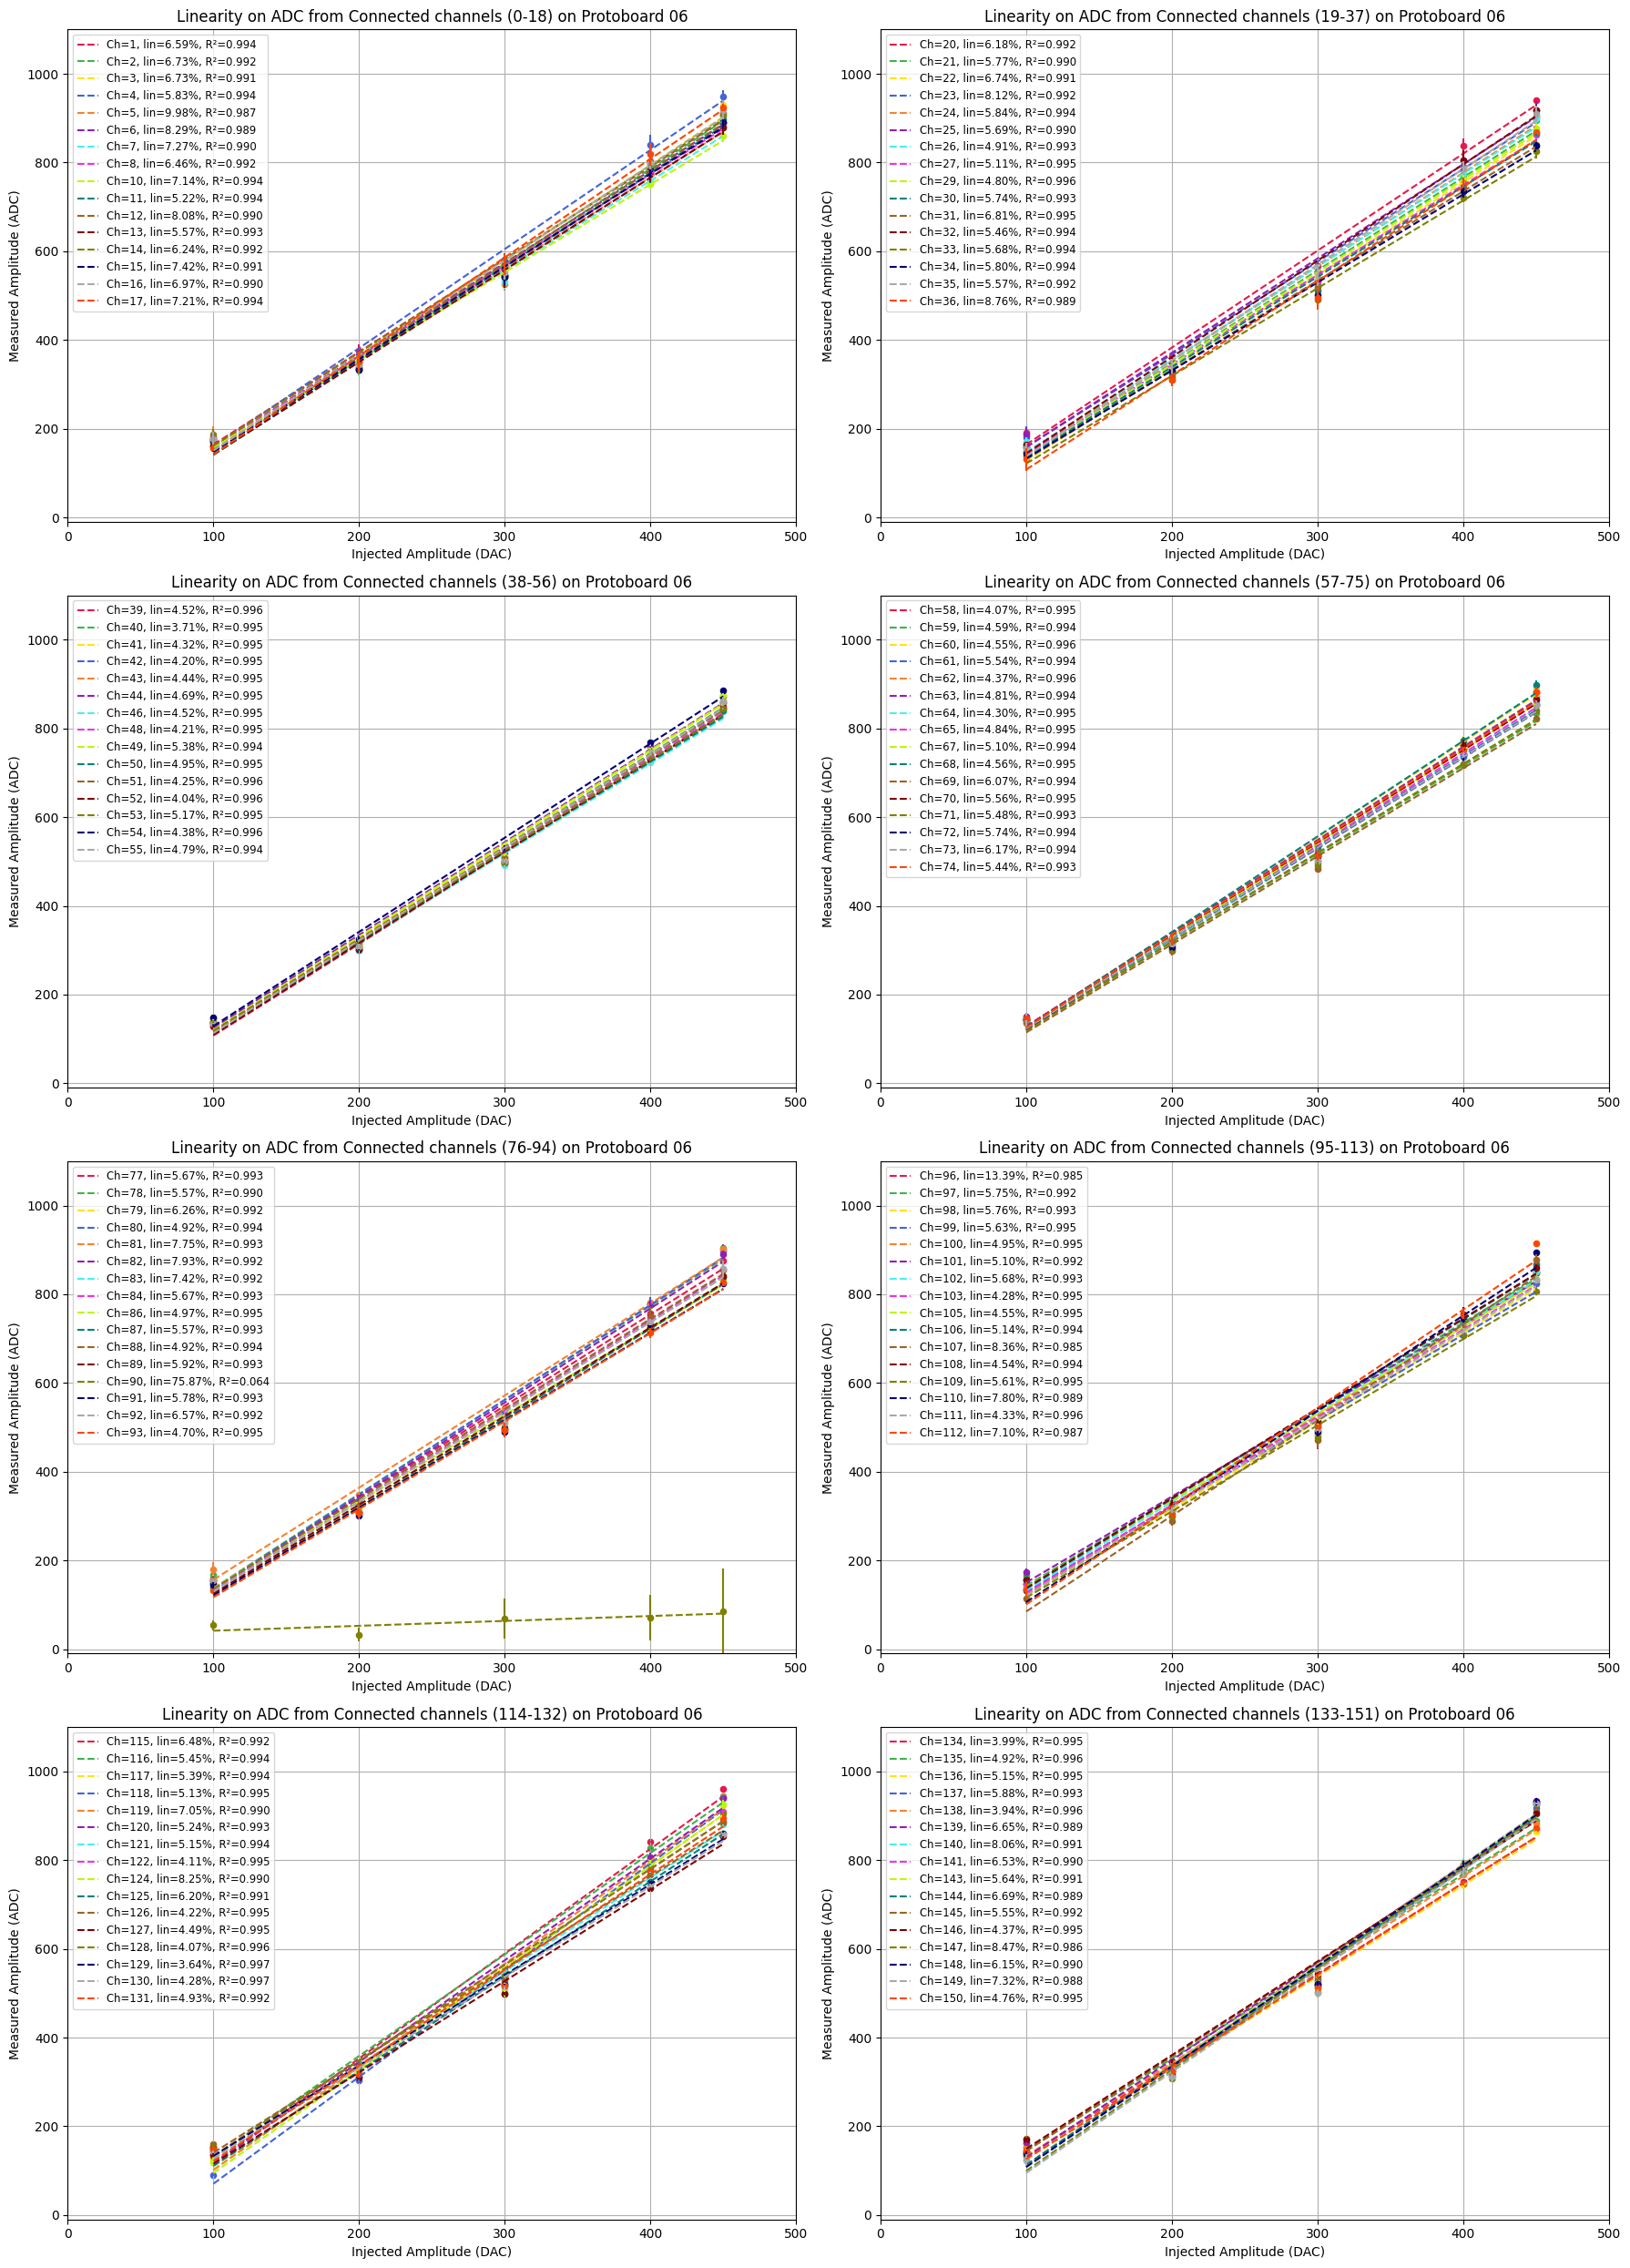


🟢 Good Linearity Channels (124 channels):
1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 20, 21, 22, 23, 24, 25, 26, 27, 29, 30, 31, 32, 33, 34, 35, 39, 40, 41, 42, 43, 44, 46, 48, 49, 50, 51, 52, 53, 54, 55, 58, 59, 60, 61, 62, 63, 64, 65, 67, 68, 69, 70, 71, 72, 73, 74, 77, 78, 79, 80, 81, 82, 83, 84, 86, 87, 88, 89, 91, 92, 93, 97, 98, 99, 100, 101, 102, 103, 105, 106, 107, 108, 109, 110, 111, 112, 115, 116, 117, 118, 119, 120, 121, 122, 124, 125, 126, 127, 128, 129, 130, 131, 134, 135, 136, 137, 138, 139, 140, 141, 143, 144, 145, 146, 147, 148, 149, 150

🔴 Bad Linearity Channels (3 channels):
36, 90, 96

Percentage of Good Linearity Channels: 96.88%

Channel R² values:
Channel 1: R² = 0.994, linearity = 4.76%
Channel 2: R² = 0.992, linearity = 4.76%
Channel 3: R² = 0.991, linearity = 4.76%
Channel 4: R² = 0.994, linearity = 4.76%
Channel 5: R² = 0.987, linearity = 4.76%
Channel 6: R² = 0.989, linearity = 4.76%
Channel 7: R² = 0.99, linearity = 4.76%
Channel 8: R² = 0.992,

In [ ]:
#sns.set_theme()
plt.style.use('default')
# Create a figure with 4x2 subplots 
fig, axs = plt.subplots(4, 2, figsize=(18, 25)) 
axs = axs.flatten() 

# Marker styles to cycle through 
markers = ['o', 's', 'D', '^', 'v', '>', '<', 'p', '*', 'h', 'X', '1', '2', '3', '4', '|'] 

line_colors = [
    "#e6194b",  # Red
    "#3cb44b",  # Green
    "#ffe119",  # Yellow
    "#4363d8",  # Blue
    "#f58231",  # Orange
    "#911eb4",  # Purple
    "#46f0f0",  # Cyan
    "#f032e6",  # Magenta
    "#bcf60c",  # Lime
    "#008080",  # Teal
    "#9a6324",  # Brown
    "#800000",  # Maroon
    "#808000",  # Olive
    "#000075",  # Navy
    "#a9a9a9",  # Dark Gray
    "#ff4500",  # Orange Red
    "#228b22",  # Forest Green
    "#1e90ff",  # Dodger Blue
    "#8b008b",  # Dark Magenta
]


# Define sets of channels to skip 
dead_channels = {0, 37, 38, 75, 76, 113, 114, 151}
calibration_channels = {19, 57, 95, 133}
notConnected_channels = {9, 18, 28, 47, 56, 66, 85, 94, 104, 123, 132, 142}

# Discarded channels for each protoboard. Channels that has an unstable behavior and should not be considered for the linearity test.
discarded_channels_dict = {
    '01': {20, 25, 43, 52, 127, 139},  # Protoboard 01
    '06': {36, 90, 96},  # Protoboard 06
    '008': {}  # Protoboard 008
}

# Total groups 
num_groups = 8 
files_per_group = 19

colors = np.random.rand(19)

# Pedestal files for each protoboard
pedestal_file_path = {'01': '/home/eic/Documents/HGCSoft/h2gcalib_3b/internalinjection/0dac/inj_adc_samples_208_pb01_76I_0_1.csv', 
                      '008': '/home/eic/Documents/HGCSoft/h2gcalib_3b/internalinjection/0dac/inj_adc_samples_209_pb008_76I_0_1.csv',
                      '06': '/home/eic/Documents/HGCSoft/h2gcalib_3b/internalinjection/0dac/inj_adc_samples_210_pb06_76I_0_1.csv'}

# Default pedestal values for each protoboard from the pedestal calibration files
default_pedestals = {'01': {79: 35, 83: 50, 115: 80, 116: 76, 117: 75},
                     '008': {},
                     '06': {}}

# Linearity Test
acceptance_value = 0.98  # R² threshold for good linearity
good_linearity_channels = []
bad_linearity_channels = []

channel_r2_dict = {} # Dictionary to store channel and its R² value

# Loop over 8 groups 
for group_id in range(num_groups):
    j=1
    ax = axs[group_id]  # Select subplot 
    first_channel = group_id * files_per_group 
    last_channel = first_channel + files_per_group 
    marker_index = 0 
    j = 0

    for i in range(first_channel, last_channel): 
        if i in dead_channels or i in notConnected_channels or i in calibration_channels or i == 45: 
            #print(f"Skipping channel: {i}") 
            continue 

        # if i != 52:
        #     continue

        #amplitudes, peaks = extract_peaks(all_dirs, i, pedestals)
        amplitudes, peaks = extract_peaks_pedestals_dynamic(all_dirs, i, pb=pb_adc, pedestal_files=pedestal_file_path, default_pedestals=default_pedestals)

        # Converting amplitude to C 
        amplitudes_array = np.array(amplitudes) 
        #mplitudes_pC = amplitudes_array*2.0752/1000

        # Linear regression 
        slope, intercept, r_value, p_value, std_err = linregress(amplitudes_array, peaks)
        
        # compute deviation
        deviations = peaks - (slope * amplitudes_array + intercept)
        max_deviation = np.max(np.abs(deviations))
        full_scale = np.max(peaks) - np.min(peaks)
        linearity_percentage = max_deviation / full_scale * 100

        # Round r_value to 3 decimal places
        r2 = round(r_value**2, 3)

        channel_r2_dict[i] = r2  # Store the R² value for the channel

        # Compute the mean value in peaks per amplitude
        peaks_np = np.array(peaks)
        means = peaks_np.reshape(-1,5).mean(axis=1)
        std_dev = peaks_np.reshape(-1,5).std(axis=1)
        
        #ax.scatter(amplitudes[4::5], means, s=20, c=line_colors[j % len(line_colors)], marker='o')
        ax.scatter(amplitudes[4::5], means, s=20, marker='o', c=line_colors[j % len(line_colors)])
        ax.errorbar(amplitudes[4::5], means, yerr=std_dev, fmt='', linestyle="None", c=line_colors[j % len(line_colors)])
        #ax.errorbar(amplitudes[4::5], means, yerr=std_dev, fmt='', linestyle="None")
        # R²={r_value**2:.1f}
        ax.plot(amplitudes_array, slope*amplitudes_array + intercept, linestyle="--", color=line_colors[j % len(line_colors)], label=f'Ch={i}, lin={linearity_percentage:.2f}%, R²={r2:.3f}') 
        if r2 >= acceptance_value and i not in discarded_channels_dict.get(pb_adc, set()):
            good_linearity_channels.append(i)
        else:
            bad_linearity_channels.append(i)

        j += 1
        marker_index += 1
        
    ax.set_title(f'Linearity on ADC from Connected channels ({first_channel}-{last_channel - 1}) on Protoboard {pb_adc}') 
    ax.set_xlabel('Injected Amplitude (DAC)') 
    ax.set_ylabel('Measured Amplitude (ADC)') 
    #ax.plot(amp, slope_ideal*amp + intercept_ideal, linestyle="-", color='black', label='Ideal Linearity')
    ax.set_ylim(-10, 1100)
    ax.set_xlim(0,500)
    ax.grid(True) 
    ax.legend(fontsize='small',markerscale=1)
    #ax.legend()

# Adjust layout 
plt.tight_layout() 
plt.show()
#fig.savefig(f'/home/eic/Documents/HGCSoft/h2gcalib_3b/internalinjection/images/FPGA_{fpga_adc}_pb{pb_adc}/06_linearity_adc_pb{pb_adc}.png')

# Output function to print channel lists
def print_channel_list(label, channels):
    print(f"\n{label} ({len(channels)} channels):")
    print(", ".join(str(int(c)) for c in sorted(channels)))
# Display the results
print_channel_list("🟢 Good Linearity Channels", good_linearity_channels)
print_channel_list("🔴 Bad Linearity Channels", bad_linearity_channels)

# Percerntage of good linearity channels
total_channels = 128
percentage_good = (len(good_linearity_channels) / total_channels) * 100 if total_channels > 0 else 0
print(f"\nPercentage of Good Linearity Channels: {percentage_good:.2f}%")

# Output the R² dictionary
print("\nChannel R² values:")
for channel, r2 in sorted(channel_r2_dict.items()):
    print(f"Channel {channel}: R² = {r2}, linearity = {linearity_percentage:.2f}%")


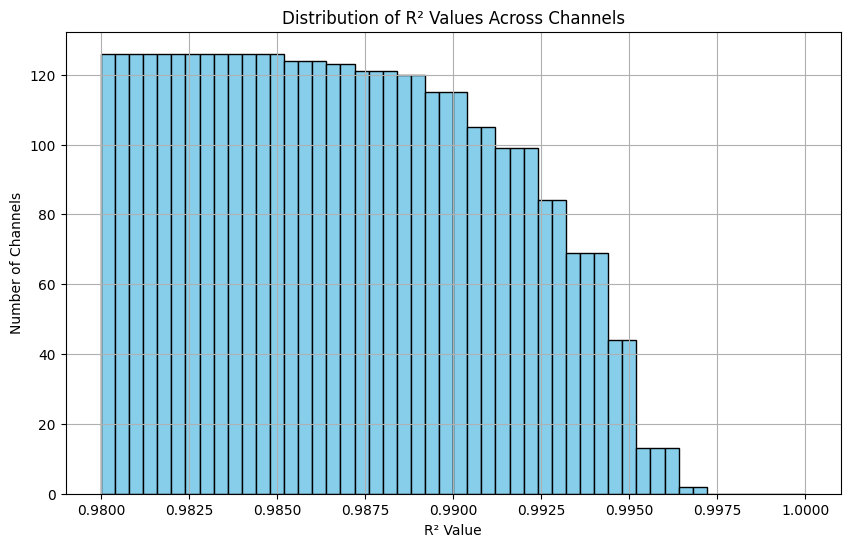

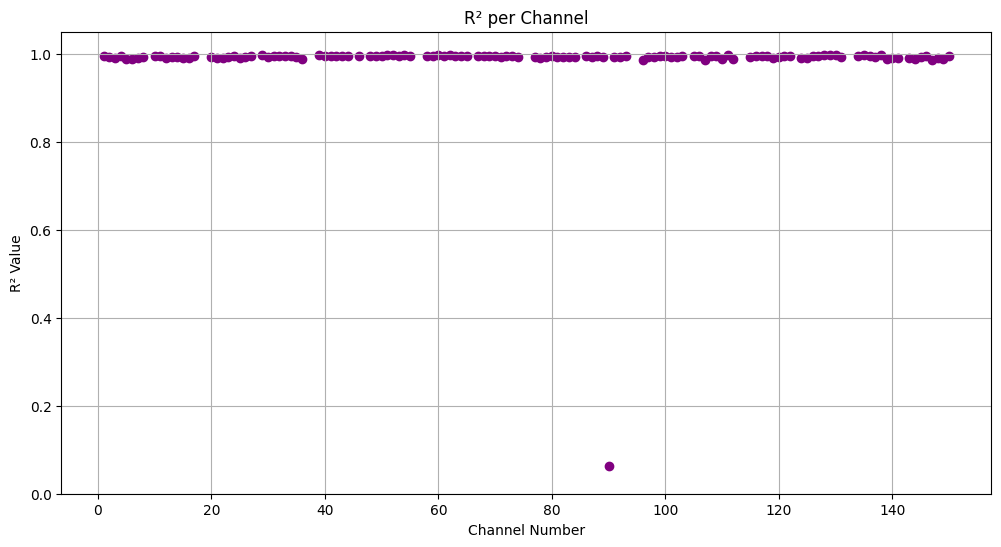

In [ ]:


# Extract data from the dictionary
channels = list(channel_r2_dict.keys())
r2_values = list(channel_r2_dict.values())

# 1. Histogram of R² values
plt.figure(figsize=(10, 6))
plt.grid(True)
plt.hist(r2_values, bins=50, color='skyblue', edgecolor='black', range=(0.98, 1), cumulative=-1)
plt.title('Decreasing Cumulative Distribution of R² Values Across Channels')
plt.xlabel('R² Value')
plt.ylabel('Number of Channels')
#plt.xlim(0.98, 1)
plt.show()

# 2. Scatter plot of R² vs Channel Number
plt.figure(figsize=(12, 6))
plt.scatter(channels, r2_values, color='purple')
plt.title('R² per Channel')
plt.xlabel('Channel Number')
plt.ylabel('R² Value')
plt.ylim(0, 1.05)
plt.grid(True)
plt.show()


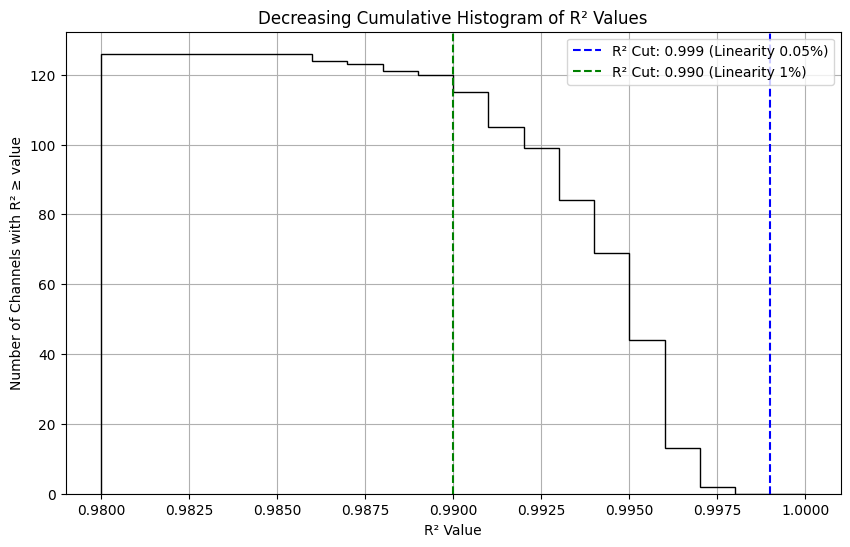

Linearity requirement: 1% → Required R² ≥ 0.99
Channels passing the cut: 115 out of 127 (90.55%)
Channels that pass the cut: [1, 2, 3, 4, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 20, 21, 22, 23, 24, 25, 26, 27, 29, 30, 31, 32, 33, 34, 35, 39, 40, 41, 42, 43, 44, 46, 48, 49, 50, 51, 52, 53, 54, 55, 58, 59, 60, 61, 62, 63, 64, 65, 67, 68, 69, 70, 71, 72, 73, 74, 77, 78, 79, 80, 81, 82, 83, 84, 86, 87, 88, 89, 91, 92, 93, 97, 98, 99, 100, 101, 102, 103, 105, 106, 108, 109, 111, 115, 116, 117, 118, 119, 120, 121, 122, 124, 125, 126, 127, 128, 129, 130, 131, 134, 135, 136, 137, 138, 140, 141, 143, 145, 146, 148, 150]


In [ ]:
# Example: Desired linearity percentage (input this value as you like)
linearity_percentage = 1 # For example: 0.05 for 0.05% or 1 for 1%

# Calculate the corresponding R² cut
r2_cut = 1.000 - (linearity_percentage / 100)

# Count the number of channels that meet the cut
passing_channels = [ch for ch, r2 in channel_r2_dict.items() if r2 >= r2_cut]
num_passing = len(passing_channels)
total_channels = len(channel_r2_dict)

# Plot the decreasing cumulative histogram
plt.figure(figsize=(10, 6))
plt.hist(r2_values, bins=20, edgecolor='black', range=(0.98, 1), cumulative=-1, histtype='step', linewidth=1)

# Draw the cut line based on linearity percentage
plt.axvline(x=0.999, color='blue', linestyle='--', label=f'R² Cut: 0.999 (Linearity 0.05%)')
plt.axvline(x=r2_cut, color='green', linestyle='--', label=f'R² Cut: {r2_cut:.3f} (Linearity {linearity_percentage}%)')

plt.title('Decreasing Cumulative Histogram of R² Values')
plt.xlabel('R² Value')
plt.ylabel('Number of Channels with R² ≥ value')
plt.grid(True)
plt.legend()
plt.show()

# Print the results
print(f"Linearity requirement: {linearity_percentage}% → Required R² ≥ {r2_cut}")
print(f"Channels passing the cut: {num_passing} out of {total_channels} ({(num_passing/total_channels)*100:.2f}%)")

# Optional: Print the channels that passed
print(f"Channels that pass the cut: {sorted(passing_channels)}")


### Print ToT for channels

File not found: /home/eic/Documents/HGCSoft/h2gcalib_3b/internalinjection/TOT_Test/400dac/inj_adc_samples_209_pb01_76_400_1.csv
File not found: /home/eic/Documents/HGCSoft/h2gcalib_3b/internalinjection/TOT_Test/400dac/inj_adc_samples_209_pb01_76_400_2.csv
File not found: /home/eic/Documents/HGCSoft/h2gcalib_3b/internalinjection/TOT_Test/400dac/inj_adc_samples_209_pb01_76_400_3.csv
File not found: /home/eic/Documents/HGCSoft/h2gcalib_3b/internalinjection/TOT_Test/400dac/inj_adc_samples_209_pb01_76_400_4.csv
File not found: /home/eic/Documents/HGCSoft/h2gcalib_3b/internalinjection/TOT_Test/400dac/inj_adc_samples_209_pb01_76_400_5.csv
File not found: /home/eic/Documents/HGCSoft/h2gcalib_3b/internalinjection/TOT_Test/925dac/inj_adc_samples_209_pb01_76_925_1.csv
File not found: /home/eic/Documents/HGCSoft/h2gcalib_3b/internalinjection/TOT_Test/925dac/inj_adc_samples_209_pb01_76_925_2.csv
File not found: /home/eic/Documents/HGCSoft/h2gcalib_3b/internalinjection/TOT_Test/925dac/inj_adc_sample

ValueError: Inputs must not be empty.

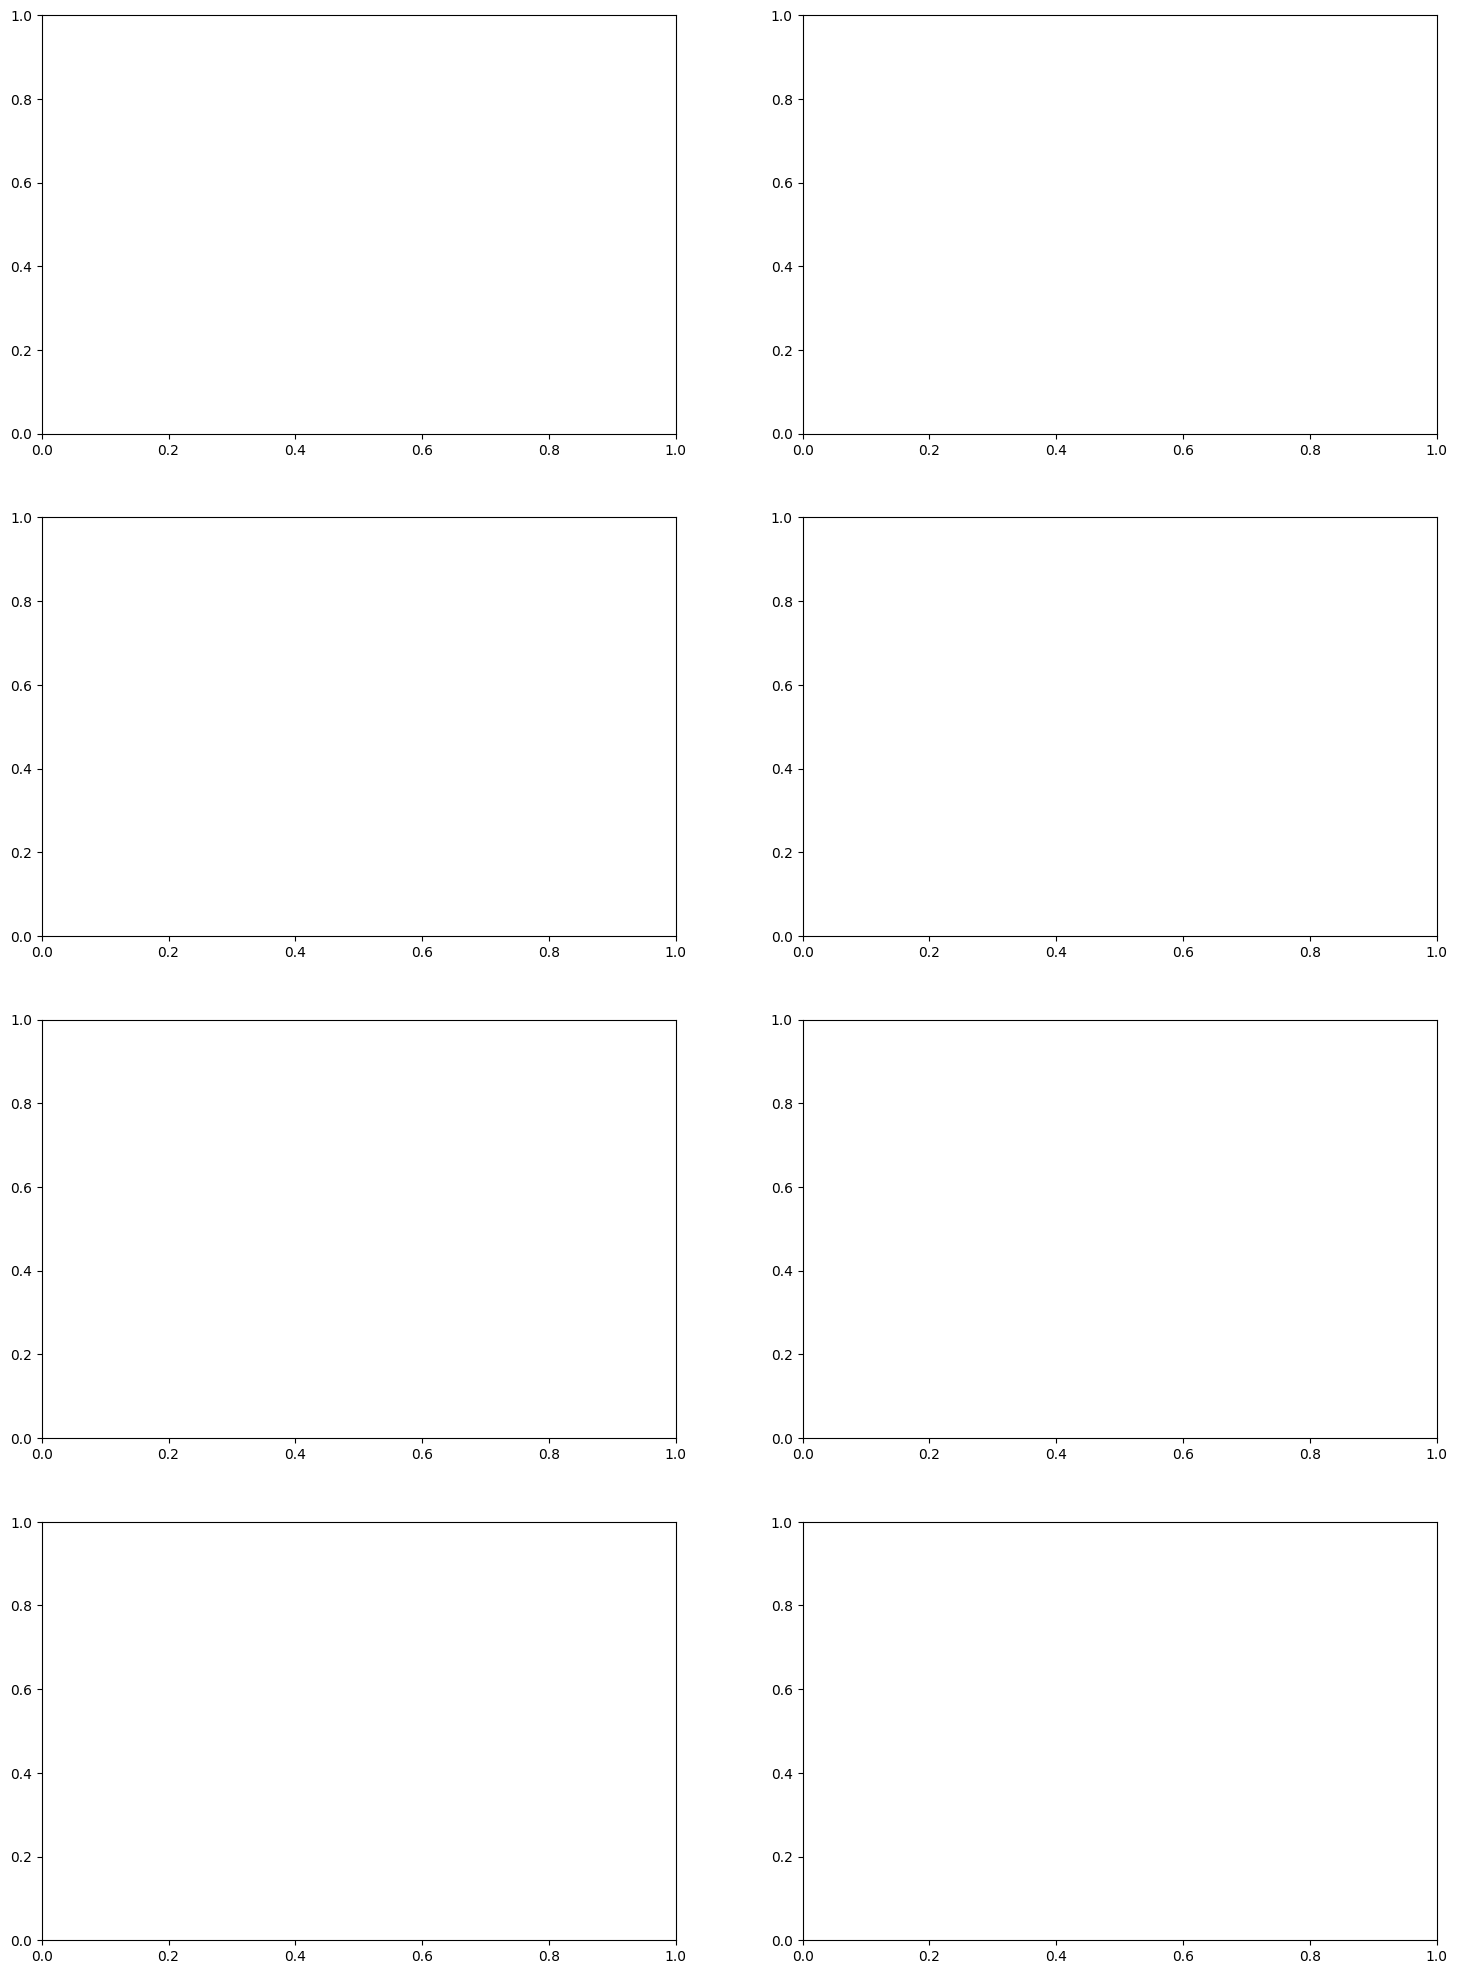

In [ ]:
#sns.set_theme()
plt.style.use('default')
# Create a figure with 4x2 subplots 
fig, axs = plt.subplots(4, 2, figsize=(18, 25)) 
axs = axs.flatten() 

# Marker styles to cycle through 
markers = ['o', 's', 'D', '^', 'v', '>', '<', 'p', '*', 'h', 'X', '1', '2', '3', '4', '|'] 

line_colors = [
    "#e6194b",  # Red
    "#3cb44b",  # Green
    "#ffe119",  # Yellow
    "#4363d8",  # Blue
    "#f58231",  # Orange
    "#911eb4",  # Purple
    "#46f0f0",  # Cyan
    "#f032e6",  # Magenta
    "#bcf60c",  # Lime
    "#008080",  # Teal
    "#9a6324",  # Brown
    "#800000",  # Maroon
    "#808000",  # Olive
    "#000075",  # Navy
    "#a9a9a9",  # Dark Gray
    "#ff4500",  # Orange Red
    "#228b22",  # Forest Green
    "#1e90ff",  # Dodger Blue
    "#8b008b",  # Dark Magenta
]


# Define sets of channels to skip 
dead_channels = {0, 37, 38, 75, 76, 113, 114, 151}
calibration_channels = {19, 57, 95, 133}
notConnected_channels = {9, 18, 28, 47, 56, 66, 85, 94, 104, 123, 132, 142}

discarded_channels = {} # Protoboard 06
#discarded_channels = {} # Protoboard 01
#discarded_channels = {} # Protoboard 008

# Total groups 
num_groups = 8 
files_per_group = 19

colors = np.random.rand(19)

pedestals = 80

good_linearity_channels = []
bad_linearity_channels = []

# Loop over 8 groups 
for group_id in range(num_groups):
    j=1
    ax = axs[group_id]  # Select subplot 
    first_channel = group_id * files_per_group 
    last_channel = first_channel + files_per_group 
    marker_index = 0 
    j = 0

    for i in range(first_channel, last_channel): 
        if i in dead_channels or i in notConnected_channels or i in calibration_channels or i == 45: 
            #print(f"Skipping channel: {i}") 
            continue 

        amplitudes, peaks = extract_tot_mean(all_dirs_tot, i, pedestals) 

        # Converting amplitude to C 
        amplitudes_array = np.array(amplitudes) 
        #mplitudes_pC = amplitudes_array*2.0752/1000

        # Linear regression 
        slope, intercept, r_value, p_value, std_err = linregress(amplitudes_array, peaks) 

        # Compute the mean value in peaks per amplitude
        peaks_np = np.array(peaks)
        means = peaks_np.reshape(-1,5).mean(axis=1)
        std_dev = peaks_np.reshape(-1,5).std(axis=1)
        
        ax.scatter(amplitudes[4::5], means, s=20, c=line_colors[j % len(line_colors)], marker='o')
        #ax.scatter(amplitudes[4::5], means, s=20, marker='o', c=line_colors[j % len(line_colors)])
        #ax.scatter(amplitudes, peaks, s=20, marker='o', c=line_colors[j % len(line_colors)])
        ax.errorbar(amplitudes[4::5], means, yerr=std_dev, fmt='', linestyle="None", c=line_colors[j % len(line_colors)])
        #ax.errorbar(amplitudes[4::5], means, yerr=std_dev, fmt='', linestyle="None")
        # R²={r_value**2:.1f}
        ax.plot(amplitudes_array, slope*amplitudes_array + intercept, linestyle="--", color=line_colors[j % len(line_colors)], label=f'Ch={i}, R²={r_value**2:.4f}') 
        if r_value**2 >= 0.98:
            good_linearity_channels.append(i)
        else:
            bad_linearity_channels.append(i)
        
        j += 1
        marker_index += 1
        
    ax.set_title(f'Linearity on ToT from Connected channels ({first_channel}-{last_channel - 1}) on Protoboard {pb}') 
    ax.set_xlabel('Injected Amplitude (DAC)') 
    ax.set_ylabel('ToT value (12-bit)') 
    #ax.plot(amp, slope_ideal*amp + intercept_ideal, linestyle="-", color='black', label='Ideal Linearity')
    ax.set_ylim(-10, 4096)
    ax.set_xlim(0,3000)
    ax.grid(True) 
    ax.legend(fontsize='small',markerscale=1)
    #ax.legend()

# Adjust layout 
plt.tight_layout() 
plt.show()
#fig.savefig(f'/home/eic/Documents/HGCSoft/h2gcalib_3b/internalinjection/images/FPGA_{fpga}_pb{pb}/01_linearity_tot_pb{pb}.png')

# Output function to print channel lists
def print_channel_list(label, channels):
    print(f"\n{label} ({len(channels)} channels):")
    print(", ".join(str(int(c)) for c in sorted(channels)))
# Display the results
print_channel_list("🟢 Good Linearity Channels", good_linearity_channels)
print_channel_list("🔴 Bad Linearity Channels", bad_linearity_channels)

# Percerntage of good linearity channels
total_channels = 128
percentage_good = (len(good_linearity_channels) / total_channels) * 100 if total_channels > 0 else 0
print(f"\nPercentage of Good Linearity Channels: {percentage_good:.2f}%")


## Individual channel

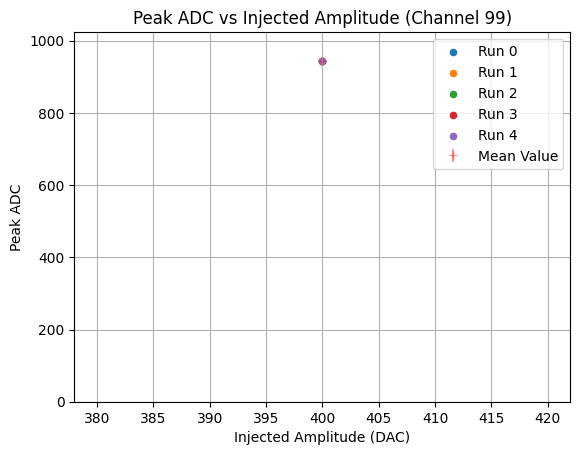

In [ ]:
# Define the channel to plot 
channel = 99
amplitude = 400

amplitudes, peaks = extract_peaks({amplitude: all_dirs[amplitude]}, channel, pedestals) 

# Converting amplitude to pC 
amplitudes_array = np.array(amplitudes) 
#amplitudes_pC = amplitudes_array*2.0752/1000 

# Standard deviation
peaks_np = np.array(peaks)
mean = peaks_np.mean()
std_dev = peaks_np.std()

# Plotting 
colors = np.random.rand(5)

fig=plt.figure() 
plt.errorbar(amplitude, mean, yerr=std_dev, fmt='+', color='red', linestyle="None", alpha=0.4, label='Mean Value')
for i in range(5):
    plt.scatter(amplitude, peaks_np[i], s=20, label=f'Run {i}')
plt.xlabel('Injected Amplitude (DAC)') 
plt.ylim(0, 1024)
plt.ylabel('Peak ADC') 
plt.legend()
plt.title(f'Peak ADC vs Injected Amplitude (Channel {channel})') 
plt.grid(True) 
plt.show() 
fig.savefig(f'/home/eic/Documents/HGCSoft/h2gcalib_3b/internalinjection/images/FPGA_{fpga}_pb{pb}/07_ADCpeak_vs_amplitude{amplitude}DAC_channel{channel}.png')


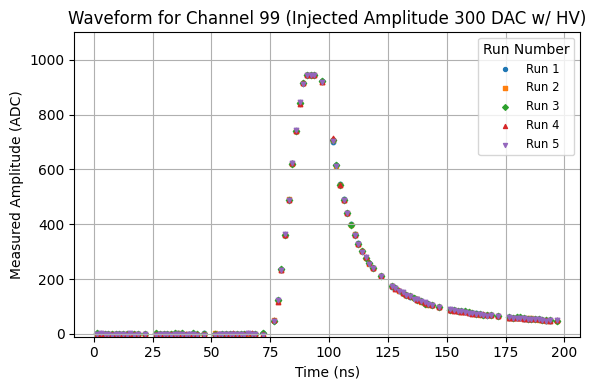

In [ ]:
# Specify the amplitude and channel you want to plot
injected_amplitude = 300  # Replace with the desired amplitude
channel = 99 # Replace with the desired channel

# Extract all the files for the specified amplitude
run_files = all_dirs.get(injected_amplitude, {})

# Check if the amplitude is valid
if not run_files:
    print(f"No files found for amplitude {injected_amplitude}")
    exit()

# Create a figure
plt.figure(figsize=(6, 4))

# Marker styles to cycle through
markers = ['o', 's', 'D', '^', 'v', '>', '<', 'p', '*', 'h', 'X', '1', '2', '3', '4', '|']
pedestals = 80

# Plot each run
for run, file_path in run_files.items():
    if not os.path.exists(file_path):
        print(f"File not found: {file_path}")
        continue
    
    # Read the data file
    df = pd.read_csv(file_path)
    df.columns = df.columns.str.strip()
    
    # Filter for the specified channel, excluding unwanted phases
    channel_data = df[(df['Channel'] == channel) & (~df['Phase'].isin([4, 6, 7]))]

    if not channel_data.empty:
        plt.scatter(channel_data['Time'], channel_data['ADC'] - pedestals,
                    label=f'Run {run + 1}',
                    marker=markers[run % len(markers)],
                    s=10)

# Customize the plot
plt.title(f'Waveform for Channel {channel} (Injected Amplitude {injected_amplitude} DAC w/ HV)')
plt.xlabel('Time (ns)')
plt.ylabel('Measured Amplitude (ADC)')
plt.ylim(-10, 1100)
plt.grid(True)
plt.legend(title="Run Number", fontsize='small', markerscale=0.9)
plt.tight_layout()
fig.savefig(f'/home/eic/Documents/HGCSoft/h2gcalib_3b/internalinjection/images/FPGA_{fpga}_pb{pb}/08_Channel{channel}-HV.png')
plt.show()


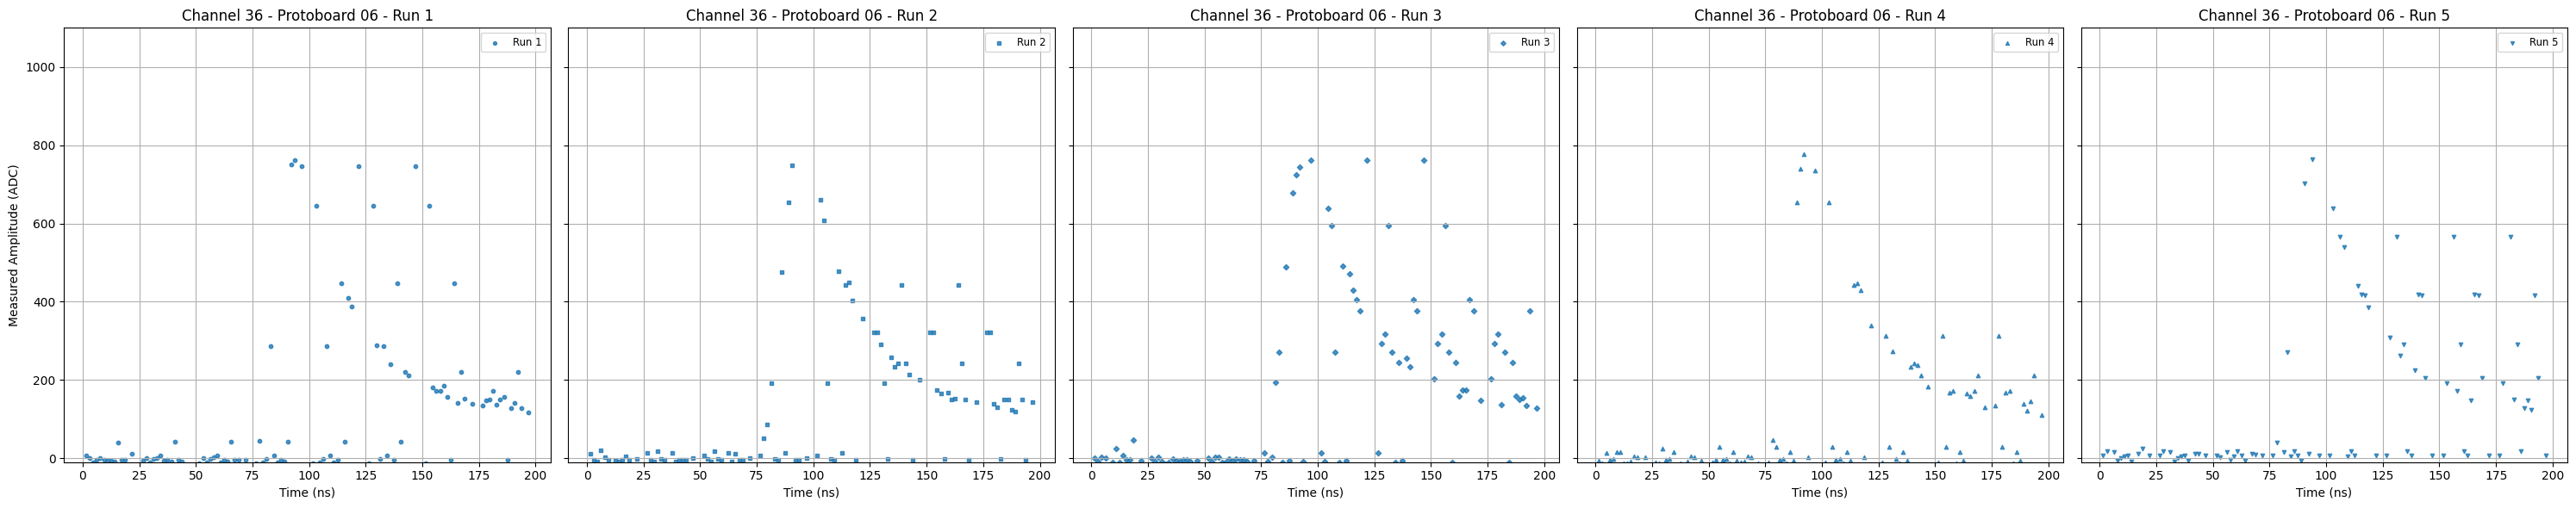

In [ ]:
# Specify the amplitude and channel you want to plot
injected_amplitude = 400  # Replace with the desired amplitude
channel = 36  # Replace with the desired channel

# Extract all the files for the specified amplitude
run_files = all_dirs.get(injected_amplitude, {})

# Create a figure with 5 separate canvases
fig, axs = plt.subplots(1, 5, figsize=(30, 6), sharey=True)

# Marker styles to cycle through
markers = ['o', 's', 'D', '^', 'v', '>', '<', 'p', '*', 'h', 'X', '1', '2', '3', '4', '|']
pedestals = 80

# Plot each run in a separate canvas
for run, file_path in run_files.items():
    # Check if the file exists
    if not os.path.exists(file_path):
        print(f"File not found: {file_path}")
        continue
    
    # Read the data file
    df = pd.read_csv(file_path)
    df.columns = df.columns.str.strip()
    
    # Filter for the specified channel, excluding unwanted phases
    channel_data = df[(df['Channel'] == channel) & (~df['Phase'].isin([4, 6, 7]))]

    if not channel_data.empty:
        # Plot on the corresponding axis
        ax = axs[run]
        ax.scatter(channel_data['Time'], channel_data['ADC'] - pedestals,
                   label=f'Run {run + 1}',
                   marker=markers[run % len(markers)],
                   s=10, alpha=0.8)
        
        # Customize the individual canvas
        ax.set_title(f'Channel {channel} - Protoboard 06 - Run {run + 1}')
        ax.set_xlabel('Time (ns)')
        ax.set_ylim(-10, 1100)
        ax.grid(True)
        ax.legend(fontsize='small', markerscale=0.9)

# Set common ylabel
axs[0].set_ylabel('Measured Amplitude (ADC)')

# Adjust layout and show the plot
plt.tight_layout()
fig.savefig(f'/home/eic/Documents/HGCSoft/h2gcalib_3b/internalinjection/images/FPGA_{fpga}_pb{pb}/Channel{channel}-{injected_amplitude}DAC-pb{pb}.png')
plt.show()


In [ ]:
std_dev


In [ ]:
fig = plt.figure(figsize=(12,6))

for i in range(10):
    filename = f'/home/eic/Documents/HGCSoft/h2gcalib_3b/internalinjection/images/FPGA_{fpga}_pb{pb}/Channel{channel}-{injected_amplitude}DAC-pb{pb}.png'
    filepath = dirs[200][i]+filename

    df = pd.read_csv(filepath)
    df.columns = df.columns.str.strip()
    plt.scatter(df['Time'], df['ADC Value'], label=f'Run{i}')

plt.title('ADC Value vs Time Channel 36')
plt.xlabel('Time (ns)')
plt.ylim(0,800)
plt.ylabel('ADC Value')
plt.legend()
plt.grid(True)
plt.show()
fig.savefig(f'/home/eic/Documents/HGCSoft/h2gcalib_3b/internalinjection/images/FPGA_{fpga}_pb{pb}/ADC_vs_Time_channel{channel}.png')


NameError: name 'dirs' is not defined

<Figure size 1200x600 with 0 Axes>

In [ ]:
fig = plt.figure(figsize=(12,6))

for i in range(10):
    filename = 'ADC_Channel_5.csv'
    filepath = dirs[750][i]+filename

    df = pd.read_csv(filepath)
    df.columns = df.columns.str.strip()
    plt.scatter(df['Time'], df['ADC Value'], label=f'Run{i}')

plt.title('ADC Value vs Time Channel 5')
plt.xlabel('Time (ns)')
plt.ylim(0,800)
plt.ylabel('ADC Value')
plt.legend()
plt.grid(True)
plt.show()
fig.savefig('ADC_vs_Time_channel5.png')


## Correct Phases

In [ ]:
all_dirs_tot


{400: {0: '/home/eic/Documents/HGCSoft/h2gcalib_3b/internalinjection/TOT_Test/400dac/inj_adc_samples_210_pb06_76_400_1.csv',
  1: '/home/eic/Documents/HGCSoft/h2gcalib_3b/internalinjection/TOT_Test/400dac/inj_adc_samples_210_pb06_76_400_2.csv',
  2: '/home/eic/Documents/HGCSoft/h2gcalib_3b/internalinjection/TOT_Test/400dac/inj_adc_samples_210_pb06_76_400_3.csv',
  3: '/home/eic/Documents/HGCSoft/h2gcalib_3b/internalinjection/TOT_Test/400dac/inj_adc_samples_210_pb06_76_400_4.csv',
  4: '/home/eic/Documents/HGCSoft/h2gcalib_3b/internalinjection/TOT_Test/400dac/inj_adc_samples_210_pb06_76_400_5.csv'},
 925: {0: '/home/eic/Documents/HGCSoft/h2gcalib_3b/internalinjection/TOT_Test/925dac/inj_adc_samples_210_pb06_76_925_1.csv',
  1: '/home/eic/Documents/HGCSoft/h2gcalib_3b/internalinjection/TOT_Test/925dac/inj_adc_samples_210_pb06_76_925_2.csv',
  2: '/home/eic/Documents/HGCSoft/h2gcalib_3b/internalinjection/TOT_Test/925dac/inj_adc_samples_210_pb06_76_925_3.csv',
  3: '/home/eic/Documents/HGC

In [ ]:
# Load the CSV file
directory = all_dirs_tot
amplitudes = [400, 925, 1450, 1975, 2500]  # List of injected amplitudes

for injected_amplitude in amplitudes:
    # Extract the first run file for the specified amplitude
    file_path = next(iter(directory.get(injected_amplitude, {}).values()), None)
    df = pd.read_csv(file_path)

    # Constants
    sample_time_interval = 25.0
    phase_time_interval = sample_time_interval / 16.0
    phase_offset = 7

    # Compute the new Phase values
    df['Phase'] = ((df['Time'] % sample_time_interval) / phase_time_interval + phase_offset).astype(int) % 16

    # Optionally, save the updated DataFrame to a new file
    df.to_csv(f"/home/eic/Documents/HGCSoft/h2gcalib_3b/internalinjection/TOT_Test/{injected_amplitude}dac/inj_adc_samples_209_pb008_76_{injected_amplitude}_1.csv", index=False)
